# Summary of output from model of COVID-19 <a class="anchor" id="home"></a>

### Table of contents

*Output from a single simulation*
* [Parameter values and assumptions](#parameter-values-assumptions)
* [Time series](#time-series)
* [Interactions between individuals](#interactions)
* [Transmission network](#transmission-network)
* [Effective reproduction number](#effective-reproduction-number)
* [Age-stratified outputs](#age-stratified-outputs)

*Notes*

Output was generated using commit number `xxxxx` of the [COVID19-IBM](https://github.com/p-robot/COVID19-IBM.git) repository on 17-Apr-20.

In [1]:
%matplotlib inline
%config InlineBackend.figure_format ='retina'
import numpy as np, pandas as pd, matplotlib.pyplot as plt
import os, re, importlib
from os.path import join
from IPython.display import display
import plotting, constant


### Model parameters

In [2]:
from COVID19.model import Model, Parameters, ModelParameterException
import COVID19.simulation as simulation


input_parameter_file = "../tests/data/baseline_parameters.csv"
parameter_line_number = 1
output_dir = "."
household_demographics_file = "../tests/data/baseline_household_demographics.csv"

### Run model

In [3]:
params = Parameters(input_parameter_file, parameter_line_number, output_dir, household_demographics_file)

T = 150
params.set_param("end_time", T)
params.set_param("n_total", 100000)

model = simulation.COVID19IBM(model = Model(params))
sim = simulation.Simulation(env = model, end_time = T)
sim.steps(150)

In [4]:
df_timeseries = pd.DataFrame(sim.results)

### Write and import output data

In [5]:
# Write output to file
sim.env.model.write_output_files()

# Import file with information on all individuals
df_indiv = pd.read_csv(join(output_dir, "individual_file_Run1.csv"), skipinitialspace = True)

# Import transmission file
df_trans = pd.read_csv(join(output_dir, "transmission_Run1.csv"))

# Import data on interactions in the last day of the simulation
df_interact = pd.read_csv(join(output_dir, "interactions_Run1.csv"))

### Import parameter file

In [6]:
# Input parameters
df_parameters = pd.read_csv(input_parameter_file)

### Define plotting constants

In [7]:
from COVID19.model import AgeGroupEnum, EVENT_TYPES, TransmissionTypeEnum
infector_types = [e.value for e in EVENT_TYPES]
infector_labels = [e.name for e in EVENT_TYPES]

interaction_types = [c.value for c in TransmissionTypeEnum ]
interaction_labels = [c.name[1:].title() for c in TransmissionTypeEnum]

infectious_compartments = ["PRESYMPTOMATIC", "PRESYMPTOMATIC_MILD", 
    "ASYMPTOMATIC", "SYMPTOMATIC", "SYMPTOMATIC_MILD"]
infectious_types = [c.name for c in constant.EVENT_TYPES if c.name in infectious_compartments]
infectious_labels = [constant.EVENT_TYPE_STRING[c.value] for c in EVENT_TYPES if c.name in infectious_compartments]

# Define age groups and labels <- FIXME: change to Enum in constant.py
n_age = len(AgeGroupEnum) + 1
age_group_labels = [enum.name[1:].replace("_","-") for enum in AgeGroupEnum]
age_group_labels[-1] = "80+"

plt.rcParams['figure.figsize'] = [14, 8]

# Parameter values and assumptions <a class="anchor" id="parameter-values-assumptions"></a>
[[Home](#home)]

Key parameter values for the simulations below.  

In [8]:
df_parameters[plotting.key_params].T.set_axis(["Parameter value"], axis = 1, inplace = False).rename_axis("Parameter name", axis = 0).reset_index().style.hide_index().set_precision(4)

Parameter name,Parameter value
n_total,1e+06
n_seed_infection,5
infectious_rate,6.75
asymptomatic_infectious_factor,0.29
mild_infectious_factor,0.48
daily_non_cov_symptoms_rate,0.002


## Waiting time distributions

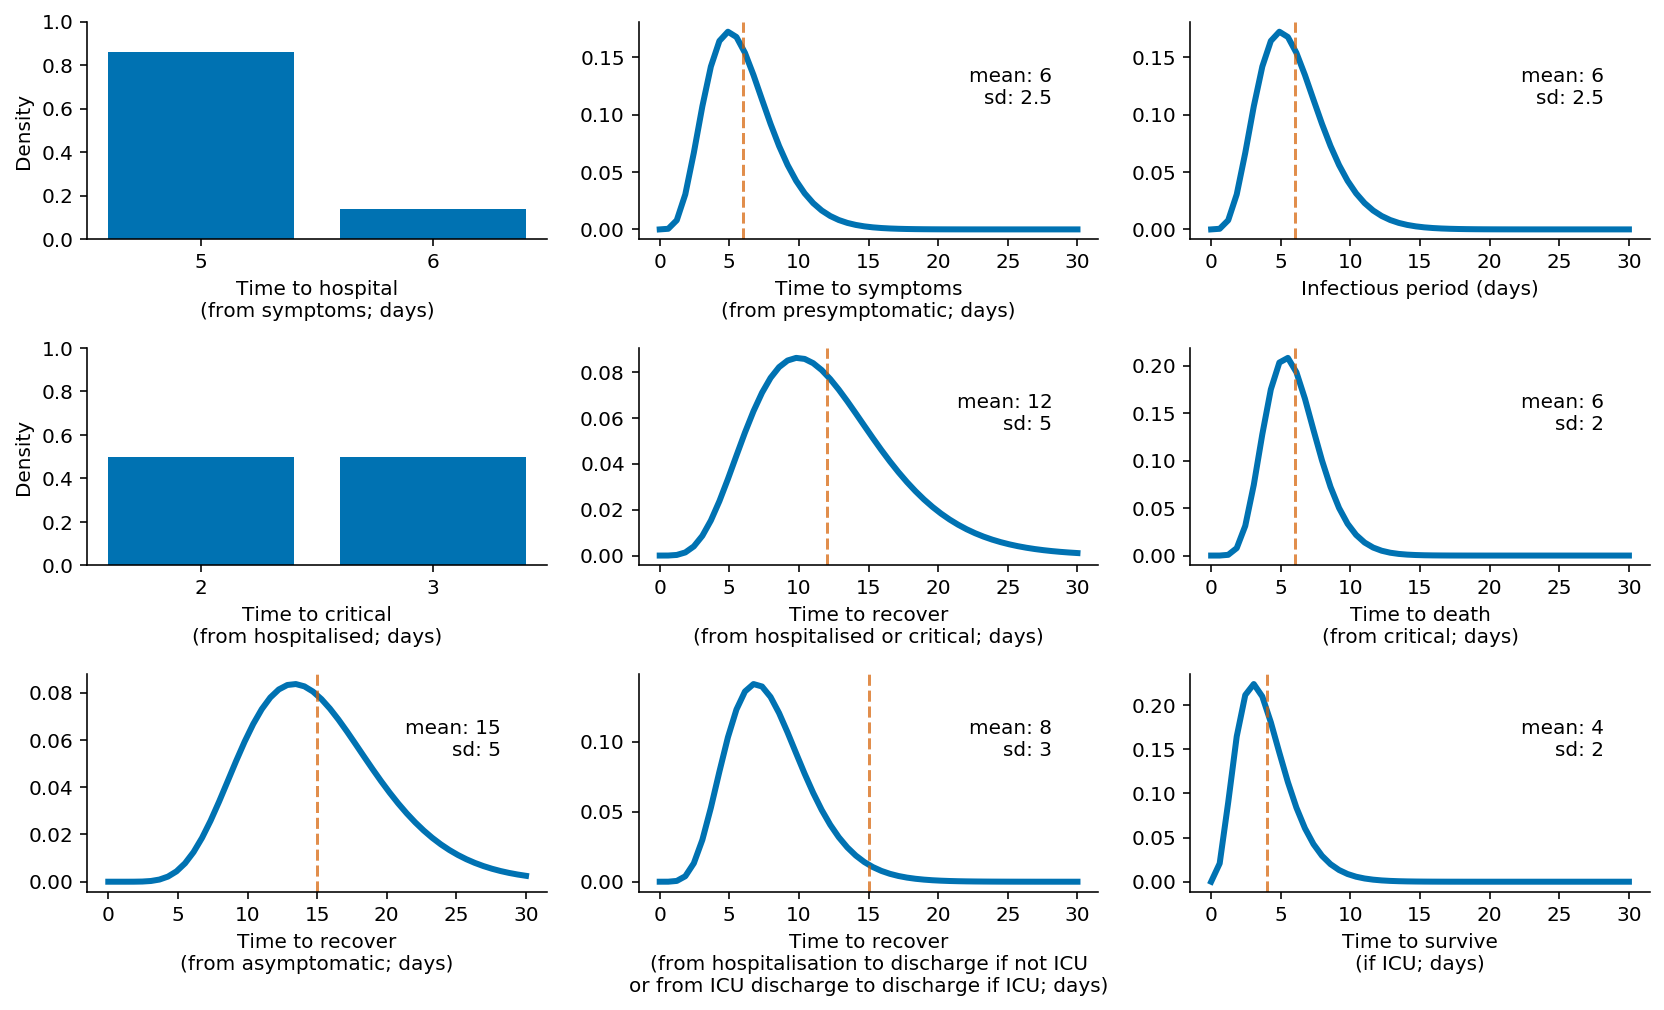

In [9]:
fig, ax = plotting.ParameterAssumptions(df_parameters)

## Age-specific parameters

In [10]:
importlib.reload(plotting)
age_params = [
    df_parameters[plotting.susceptibility_cols].values[0], # FIXME: <- adjust to use list comprehension to pull colnames
    df_parameters[plotting.asymptomatic_cols].values[0],
    df_parameters[plotting.hospitalised_cols].values[0],
    df_parameters[plotting.critical_cols].values[0],
    df_parameters[plotting.fatality_cols].values[0],
    df_parameters[plotting.mild_cols].values[0],
    df_parameters[plotting.app_users_cols].values[0]]

df = pd.DataFrame(age_params)
df.columns = age_group_labels
df.rename(index = {0:'Relative susceptibility', 
                   1:'Pr( asymptomatic | infected )',
                   2:'Pr( hospitalisation | symptomatic )',
                   3:'Pr( ICU | hospitalised )',
                   4:'Pr( death | ICU )',
                   5:'Pr( mild | infected )',
                   6:'Pr( app users )'
                  }, inplace = True)
display(df)

,0-9,10-19,20-29,30-39,40-49,50-59,60-69,70-79,80+
Relative susceptibility,0.71,0.7400,0.7900,0.8700,0.980,1.110,1.2600,1.450,1.6600
Pr( asymptomatic | infected ),0.18,0.1800,0.1800,0.1800,0.180,0.180,0.1800,0.180,0.1800
Pr( hospitalisation | symptomatic ),0.01,0.0267,0.0367,0.0633,0.800,0.120,0.1533,0.160,0.1367
Pr( ICU | hospitalised ),0.05,0.0500,0.0500,0.0500,0.063,0.122,0.2740,0.432,0.7090
Pr( death | ICU ),0.33,0.2500,0.5000,0.5000,0.500,0.690,0.6500,0.880,1.0000
Pr( mild | infected ),0.79,0.7900,0.7300,0.6800,0.650,0.590,0.5300,0.410,0.2700
Pr( app users ),0.00,0.9000,0.9600,0.9500,0.910,0.810,0.6400,0.410,0.2700


## Intervention parameters

In [11]:
df_parameters[plotting.intervention_params].T.set_axis(["Parameter value"], axis = 1, inplace = False).rename_axis("Parameter name", axis = 0).reset_index().style.hide_index().set_precision(2)

Parameter name,Parameter value
self_quarantine_fraction,0
quarantine_length_self,7
quarantine_length_traced,14
quarantine_length_positive,14
quarantine_dropout_self,0.02
quarantine_dropout_traced,0.02
quarantine_dropout_positive,0.02
test_on_symptoms,0
test_on_traced,0
quarantine_on_traced,0


# Time series <a class="anchor" id="time-series"></a>
[[Home](#home)]

Figures of the epidemic trajectory for a single parameter set.  

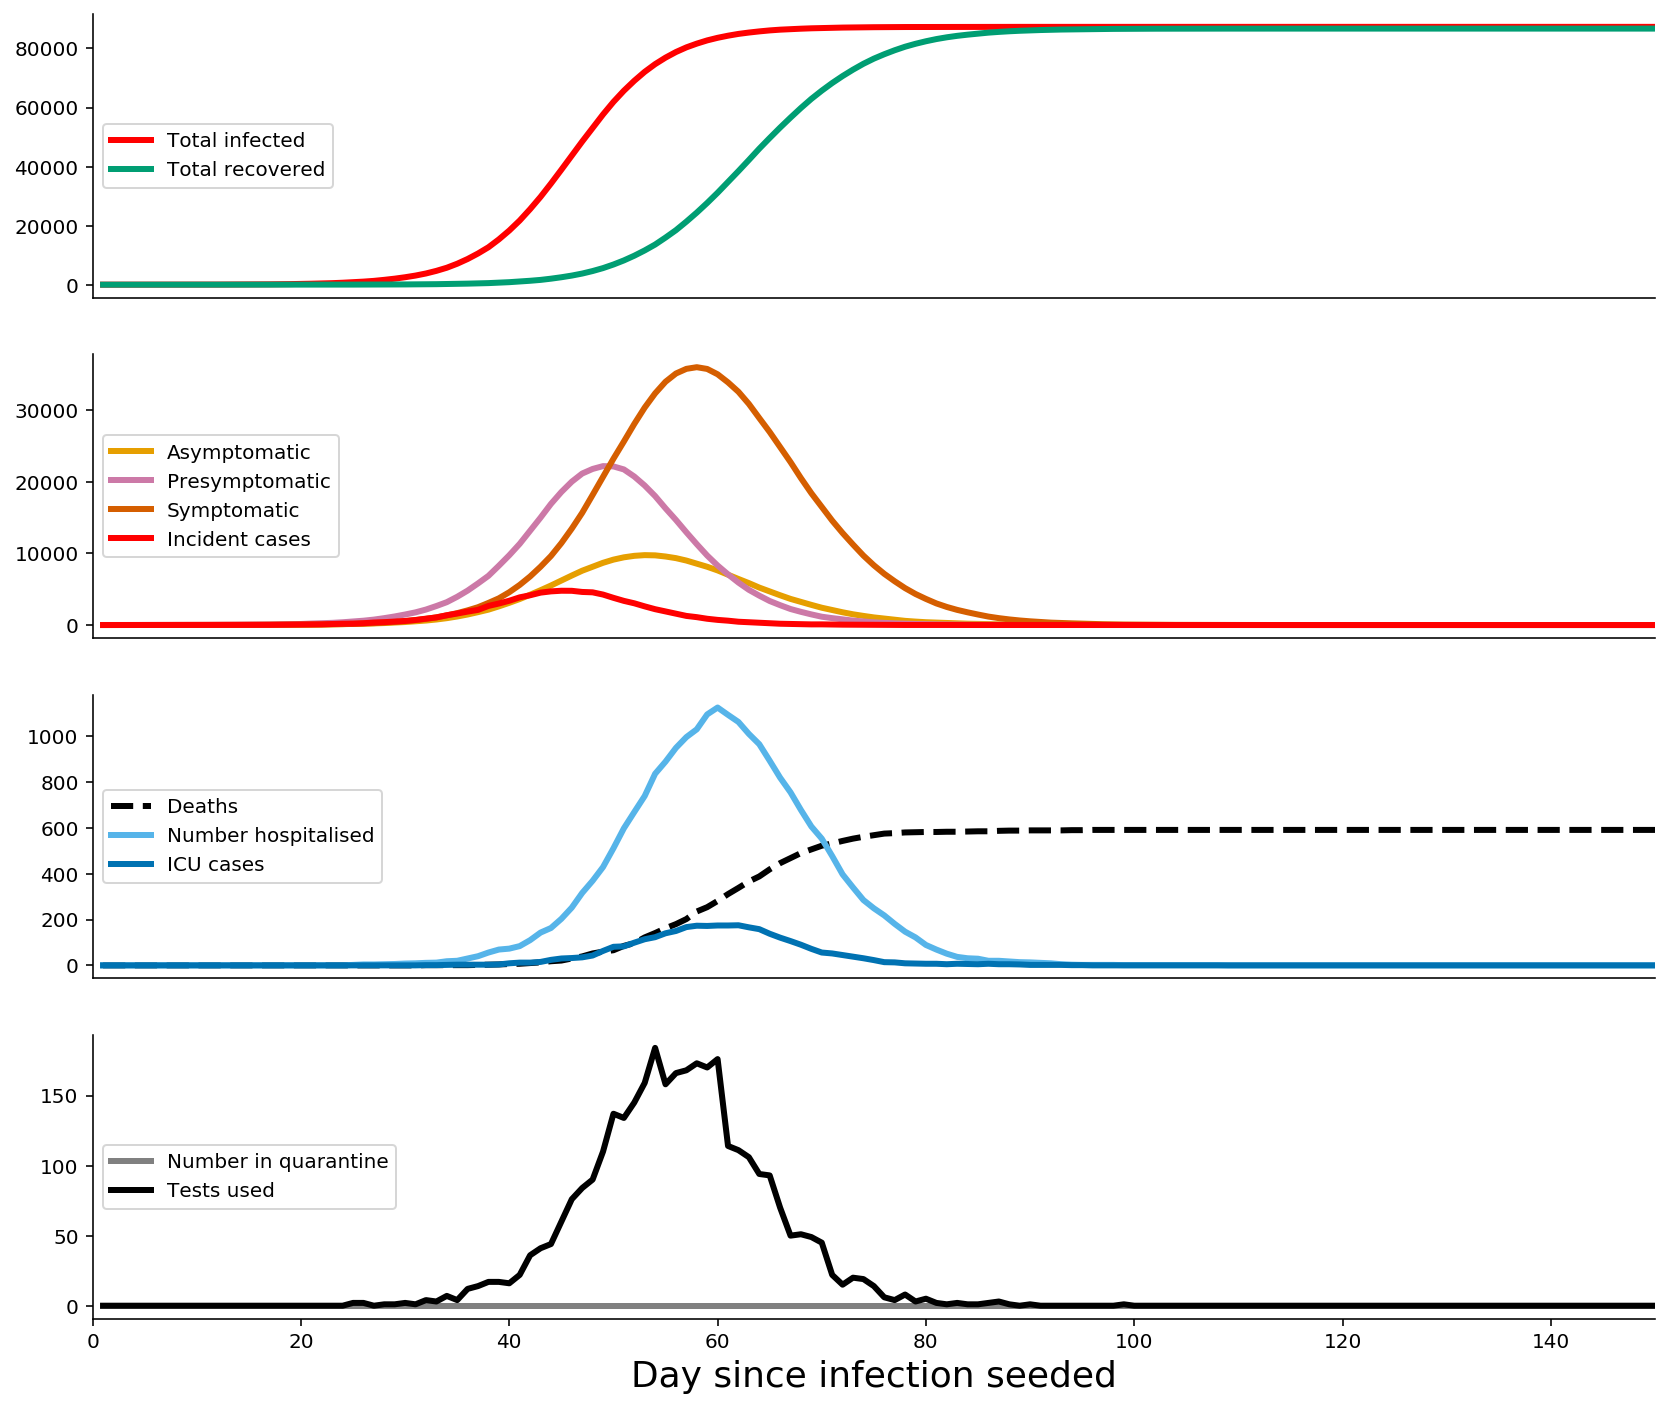

In [12]:
importlib.reload(plotting)
plt.rcParams['figure.figsize'] = [14, 12]
fig, ax = plotting.EpidemicCurves(df_timeseries, xlimits = [0, 150]) # FIXME: Update lockdown shading; add mild/severe

# Interactions <a class="anchor" id="interactions"></a>
[[Home](#home)]

Summaries of interactions within the model


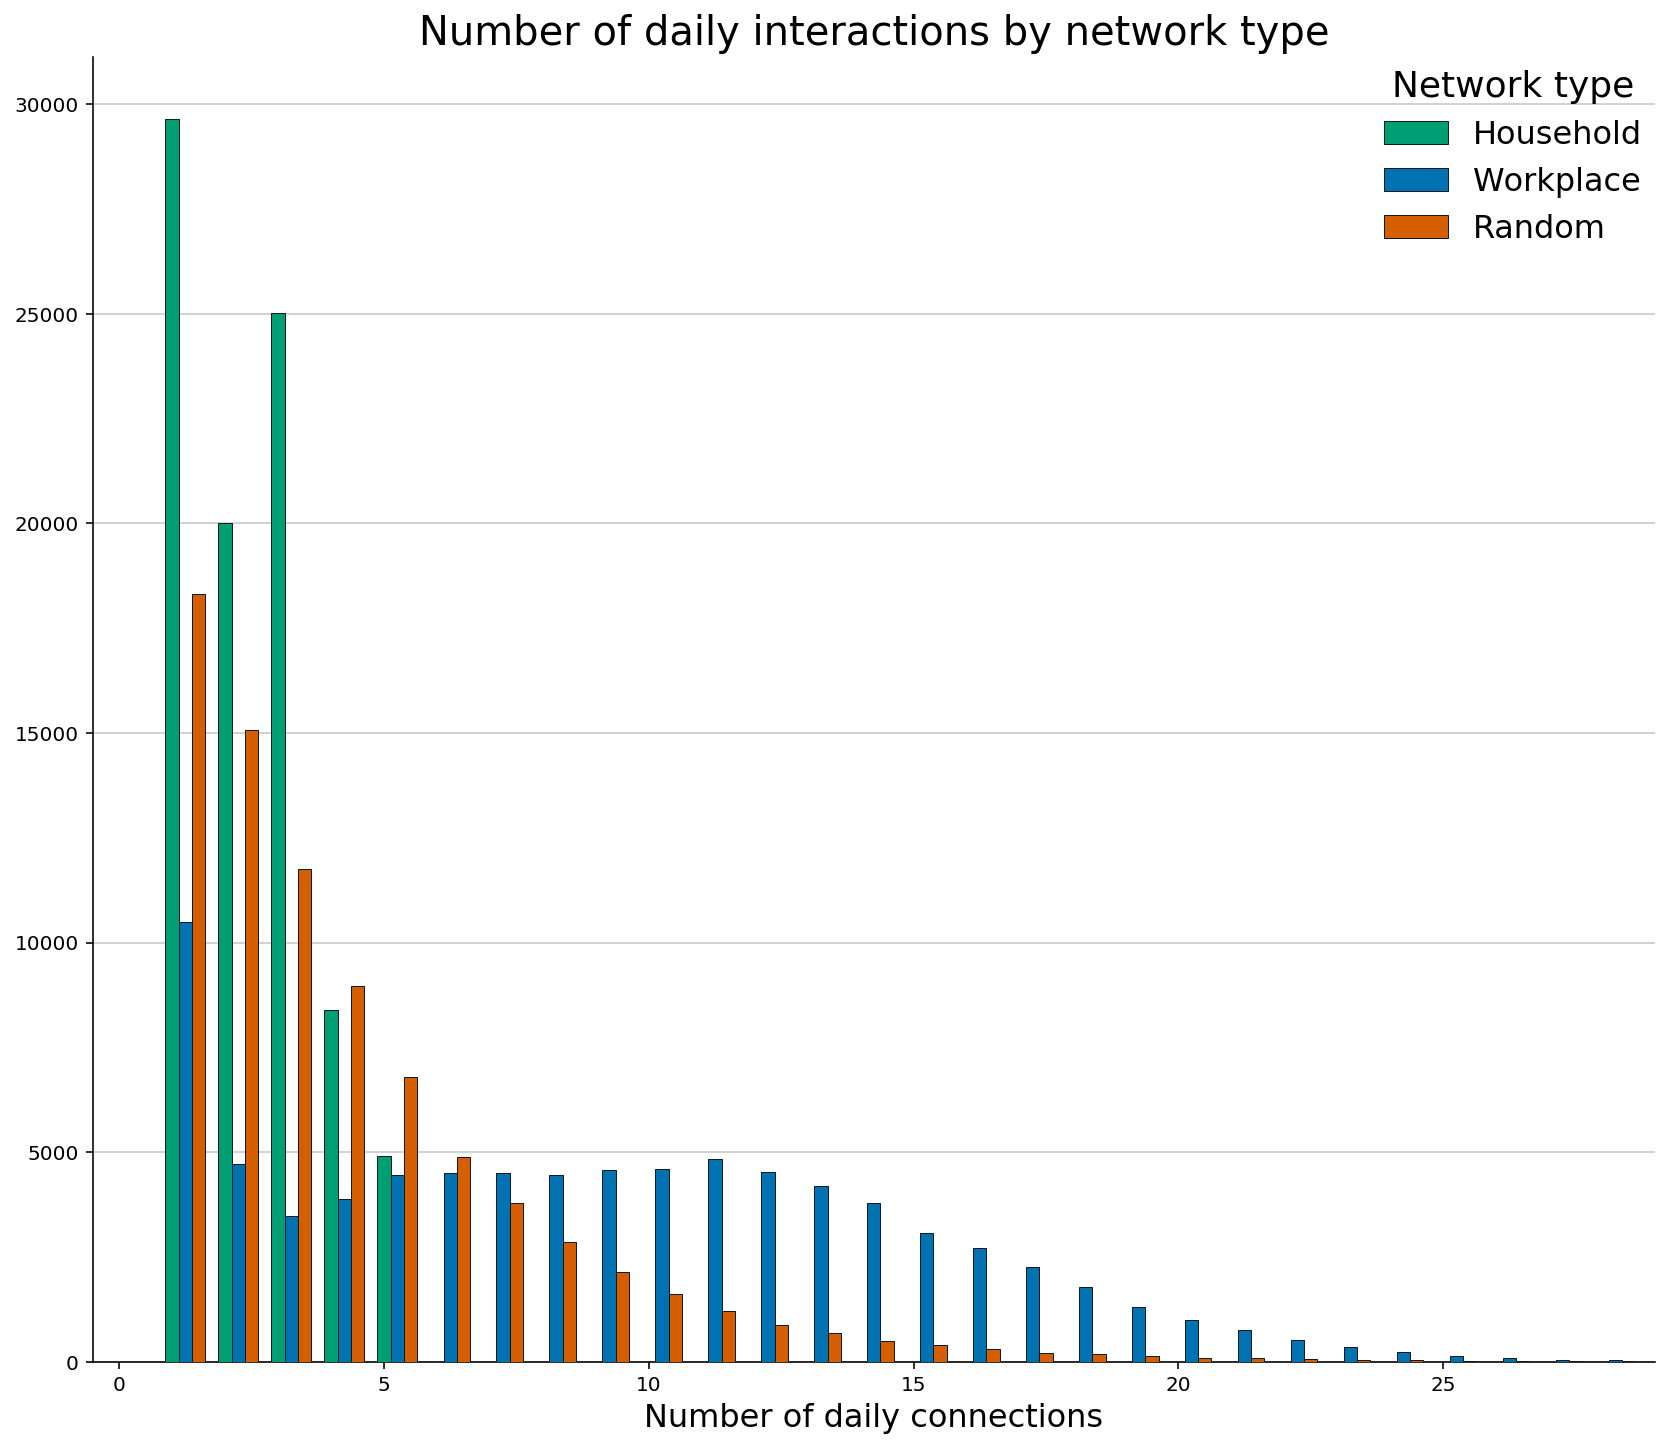

In [13]:
# Count interactions for each individual by "type" of interaction
df_agg = df_interact.groupby(["ID", "type"])["ID"].count().reset_index(name = "count")

# Plot histogram of interaction by network type
fig, ax = plotting.BarByGroup(df_agg, groupvar = "type", binvar = "count", 
    groups = interaction_types, bins = 30, group_colours = plotting.network_colours, 
    group_labels = interaction_labels, 
    xlabel = "Number of daily connections", 
    title = "Number of daily interactions by network type", 
    legend_title = "Network type")

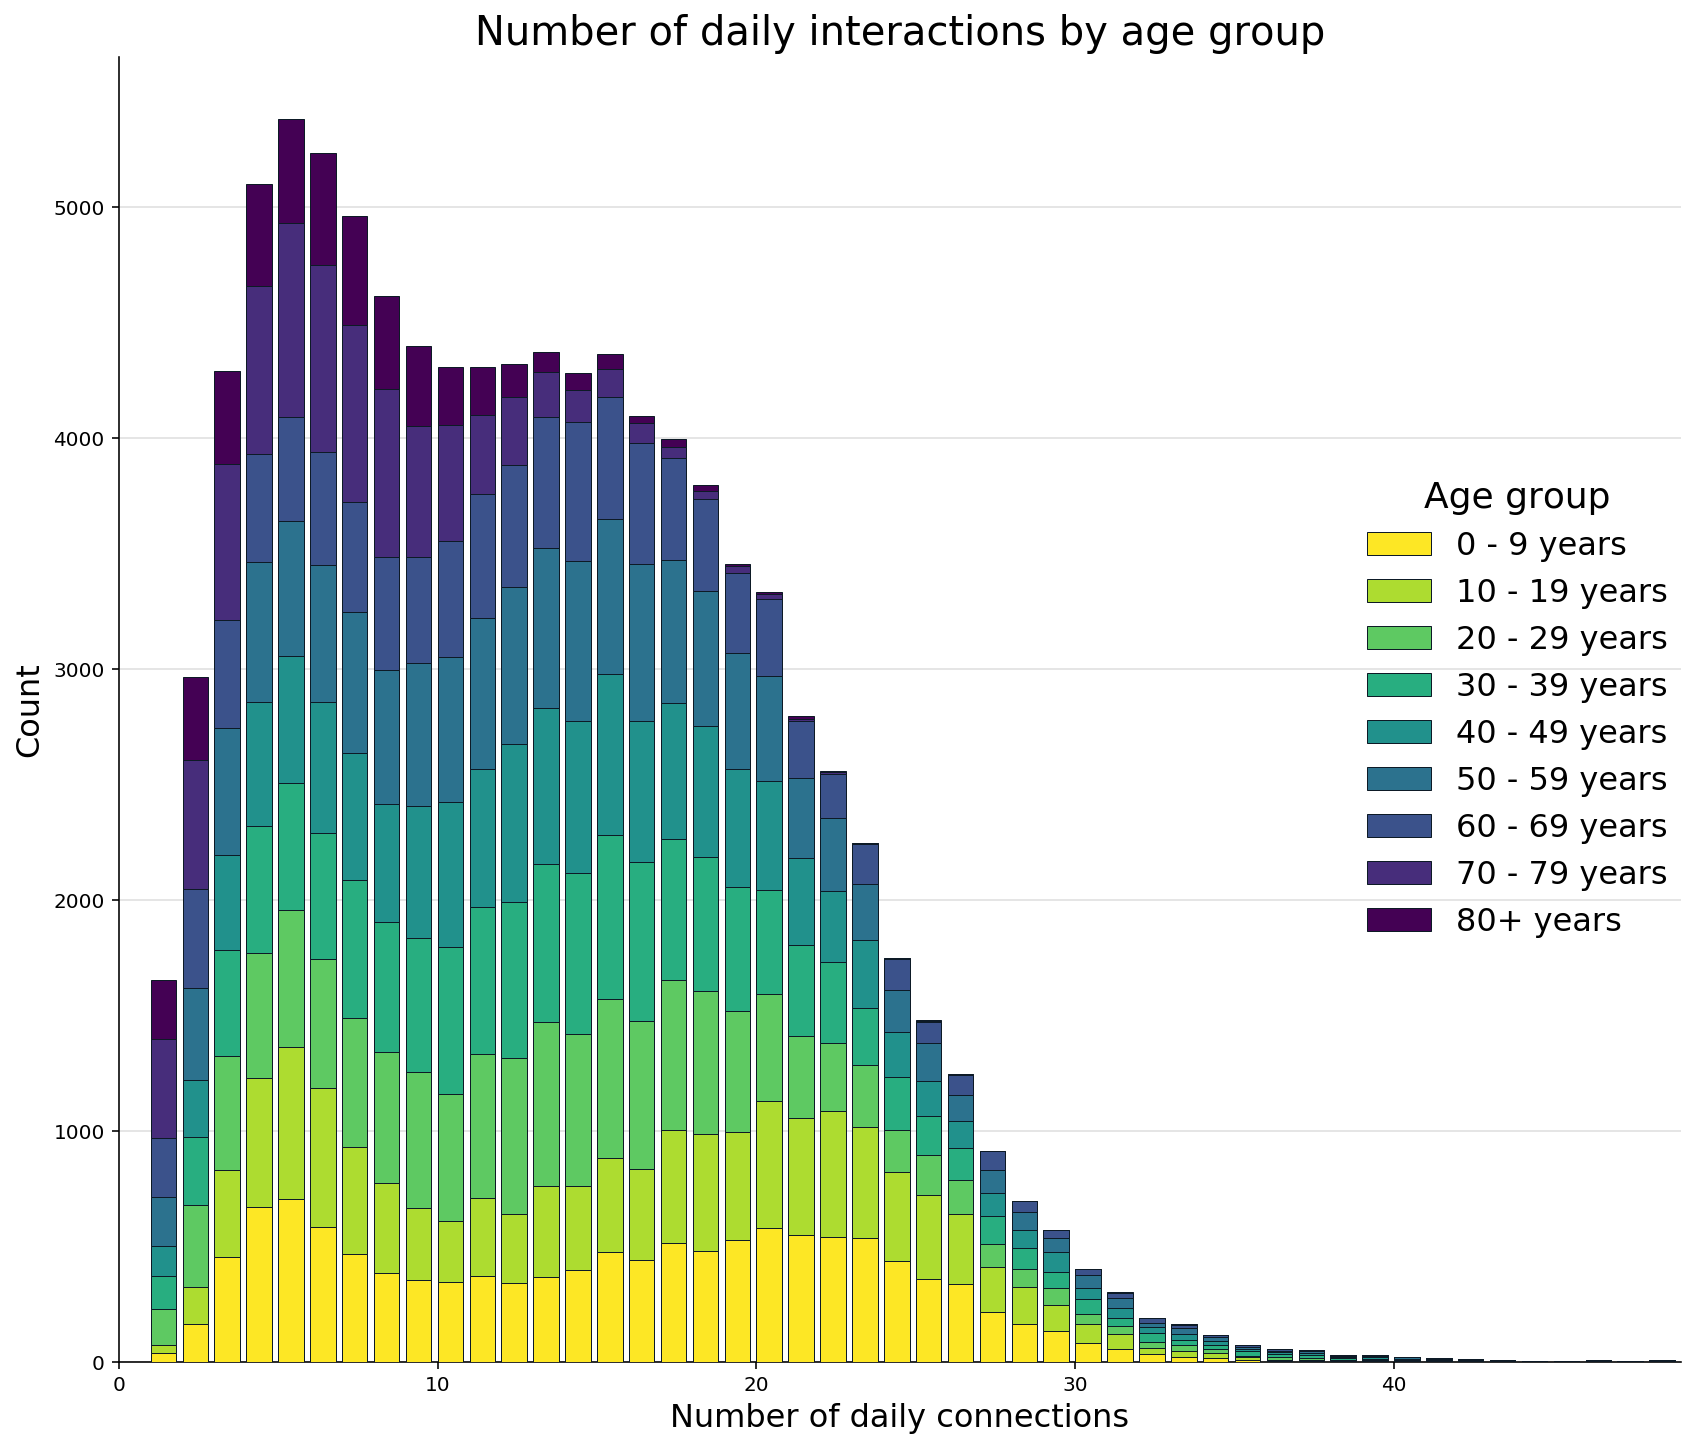

In [14]:
# Plot histogram of interaction by network type
fig, ax = plotting.PlotInteractionsByAge(df_interact)


# Transmission network <a class="anchor" id="transmission-network"></a>
[[Home](#home)]


### Proportion of all transmission from infectious status of source

In [15]:
percent_trans_infector_status = 100*df_trans.infector_status.value_counts()/df_trans.shape[0]
percent_trans_infector_status = percent_trans_infector_status.reset_index()
percent_trans_infector_status.columns = ["infector_status", "percent_transmissions"]
percent_trans_infector_status["name"] = percent_trans_infector_status.infector_status.map(lambda x: constant.EVENT_TYPE_STRING[constant.EVENT_TYPES(x).value])

display(percent_trans_infector_status[percent_trans_infector_status.percent_transmissions > 0].style.hide_index())

infector_status,percent_transmissions,name
2,33.5979,Presymptomatic (mild)
5,23.4704,Symptomatic (mild)
1,20.3534,Presymptomatic (severe)
4,12.8986,Symptomatic (severe)
3,9.67398,Asymptomatic
0,0.00572561,Uninfected


### Proportion of all transmission from infectious status of source, through time

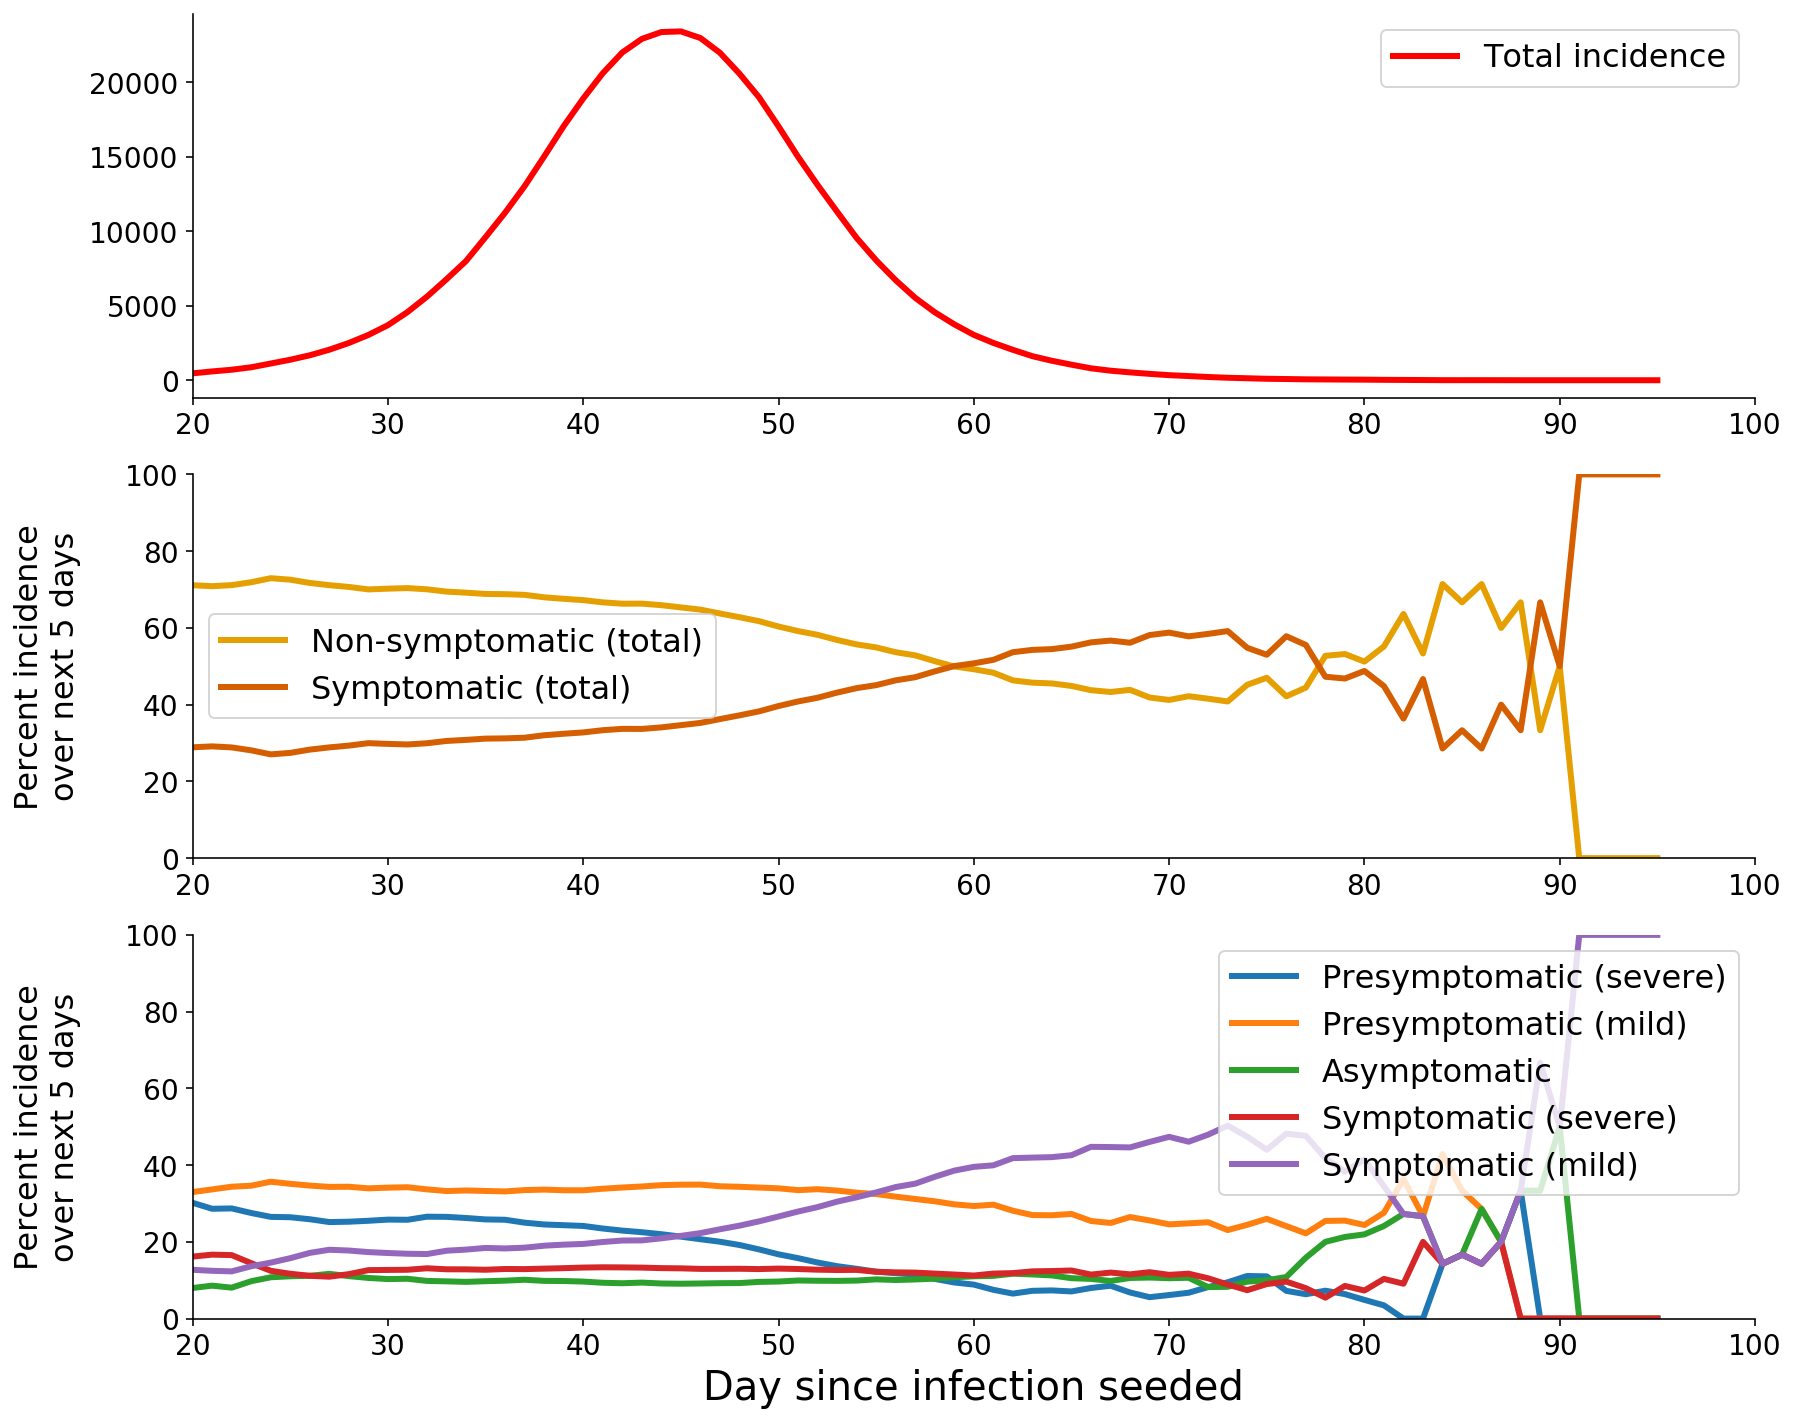

In [16]:
# Fixme update incidence calculation
plt.rcParams['figure.figsize'] = [14, 12]
fig, ax = plotting.ProportionTransmissionsThroughTime(df_trans, 
    groupvar = "infector_status", groups = infector_types, 
    infectiontimevar = "time_infected", 
    start = 20, stop = 100, window = 5, ylims = [0, 100])

### Generation time by infection status of source : fixme use infector type labels

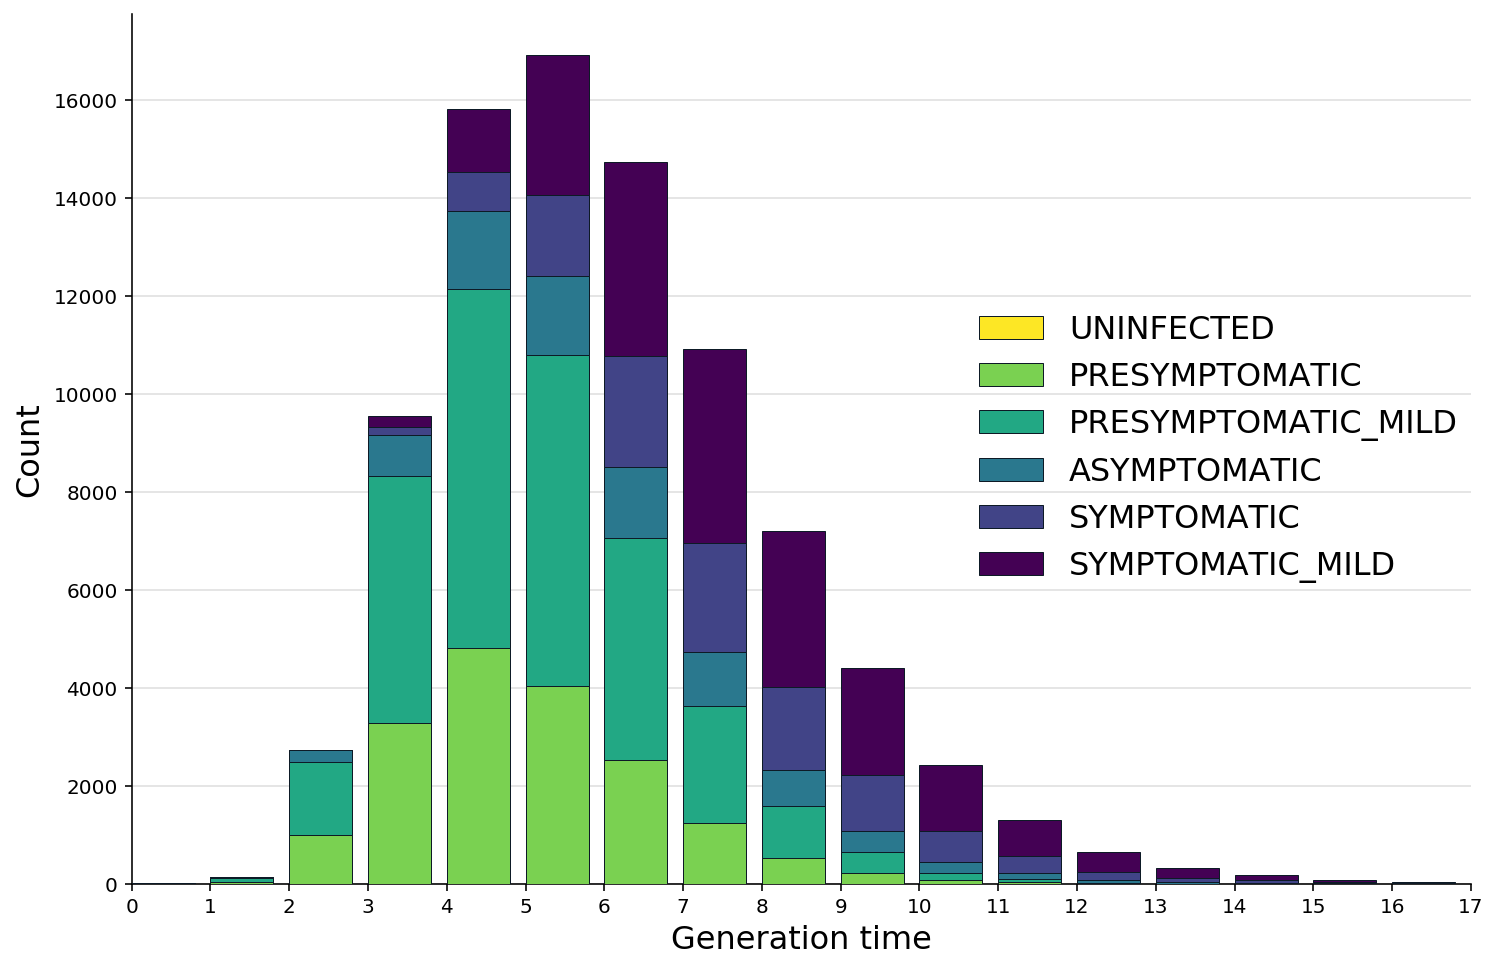

In [17]:
plt.rcParams['figure.figsize'] = [12, 8]
fig, ax = plotting.PlotStackedHistByGroup(df_trans, 
        groupvar = "infector_status", countvar = "infector_infected_time", 
        NBINS = 18, group_labels = infector_labels,
        xlabel = "Generation time", ylabel = "Count")

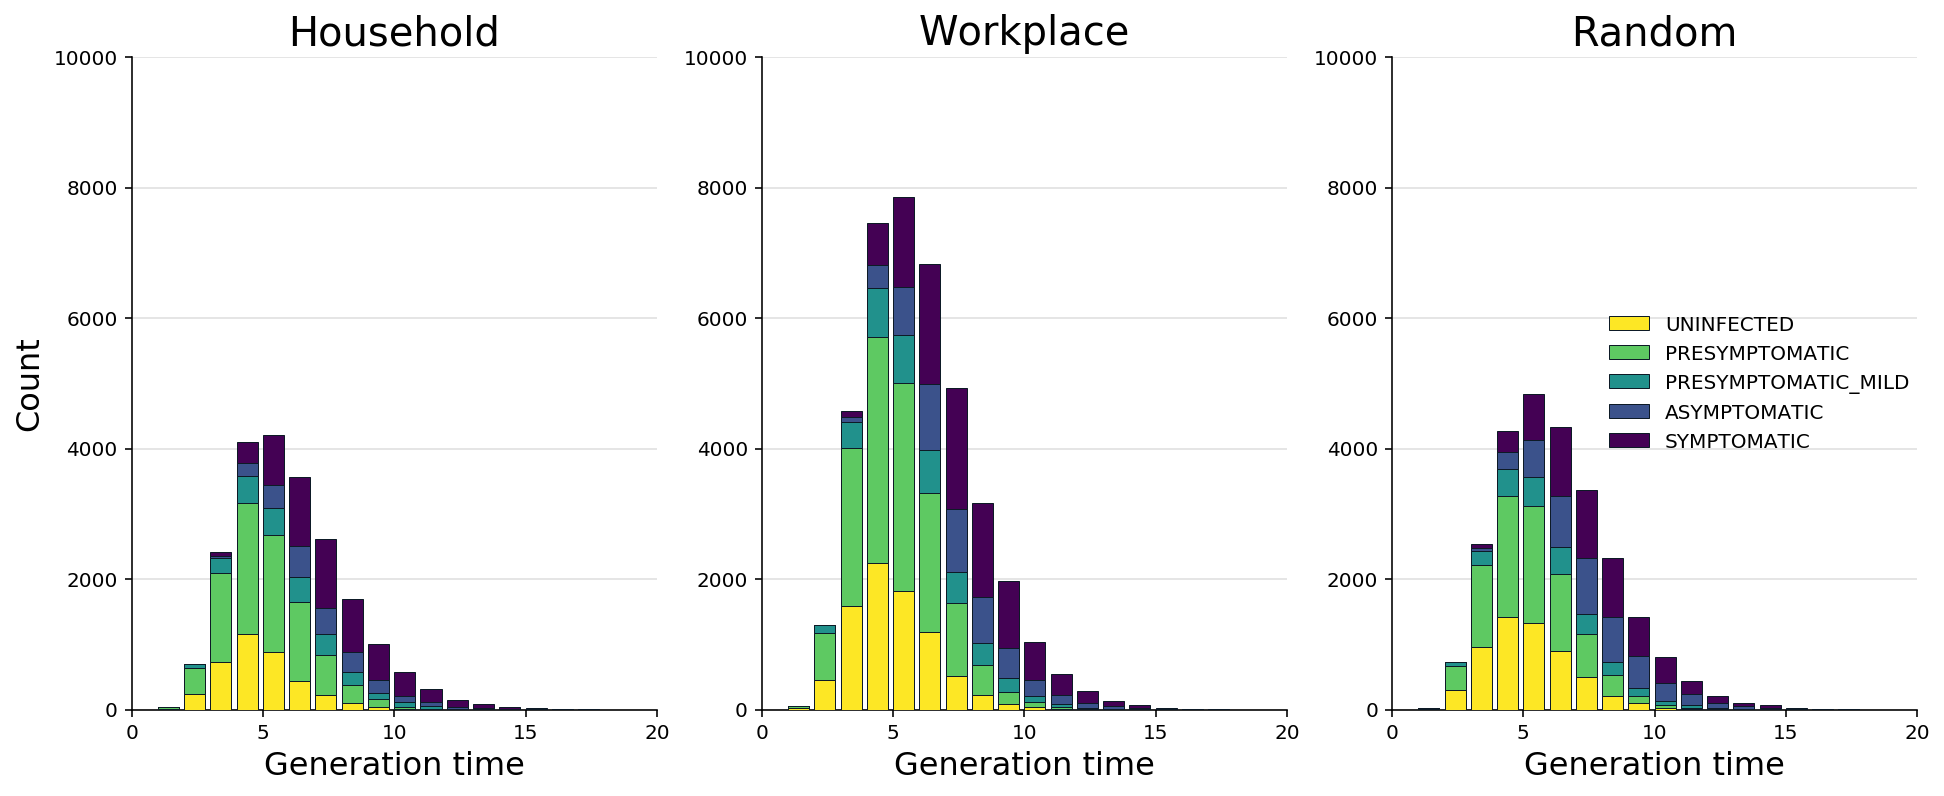

In [18]:
# fixme: use infector type labels
importlib.reload(plotting)
plt.rcParams['figure.figsize'] = [16, 6]

df_sub = df_trans[df_trans.infector_network >= 0]
max_gen_time = df_sub.infector_infected_time.max()

fig, ax = plotting.PlotStackedHistByGroupByPanel(df_sub, 
    groupvar = "infector_status", countvar = "infector_infected_time", NBINS = max_gen_time,
    panelvar = "infector_network",
    group_labels = infector_labels, ylims = [0, 10000],
    xlabel = "Generation time", ylabel = "Count", 
    panel_labels = ["Household", "Workplace", "Random"])

In [19]:
# Fixme: add plot of transmission events by age and network type
# Add plots where bars are side-by-side
# importlib.reload(plotting)
# plt.rcParams['figure.figsize'] = [16, 10]

# df_sub = df_trans[df_trans.infector_network >= 0]
# max_gen_time = df_sub.infector_infected_time.max()
# print(df_sub.head())
# fig, ax = plotting.BarByGroupByPanel(
#     df_sub,
#     binvar = "infector_infected_time", 
#     panelvar = "infector_network",
#     groupvar = "infector_status", 
#     groups = infectious_types, 
#     group_labels = infectious_labels, 
#     NBINS = max_gen_time, 
#     xlabel = "Generation time", 
#     title = "",
#     legend_title = "Network type")

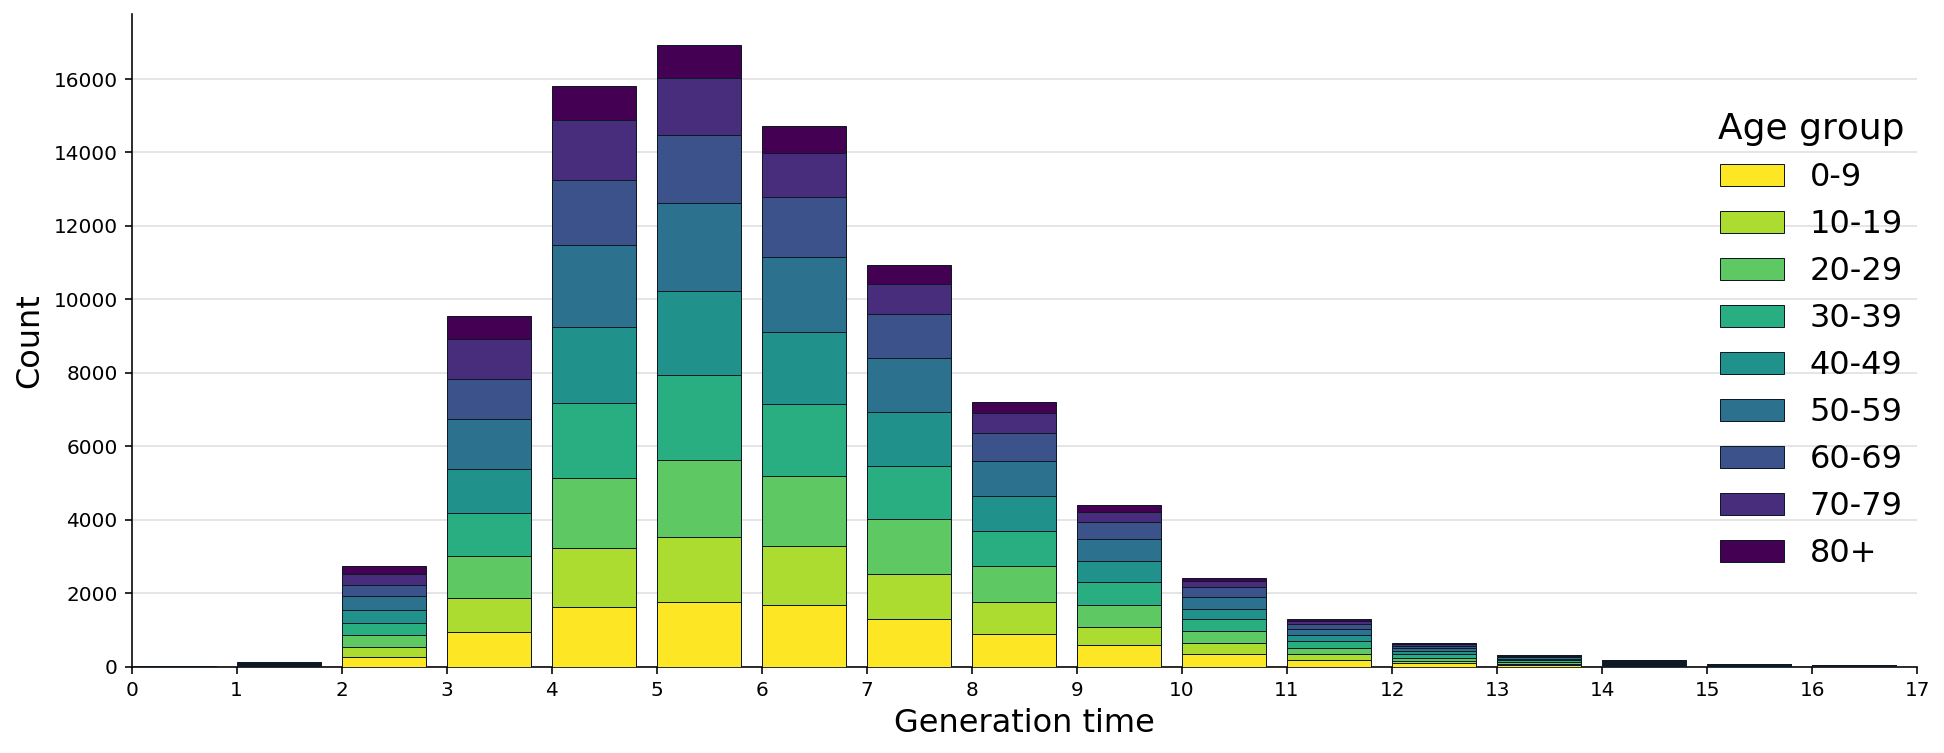

In [20]:
fig, ax = plotting.PlotStackedHistByGroup(df_trans, 
        groupvar = "age_group", countvar = "infector_infected_time", NBINS = 18,
        group_labels = age_group_labels, legend_title = "Age group",
        xlabel = "Generation time", ylabel = "Count", )

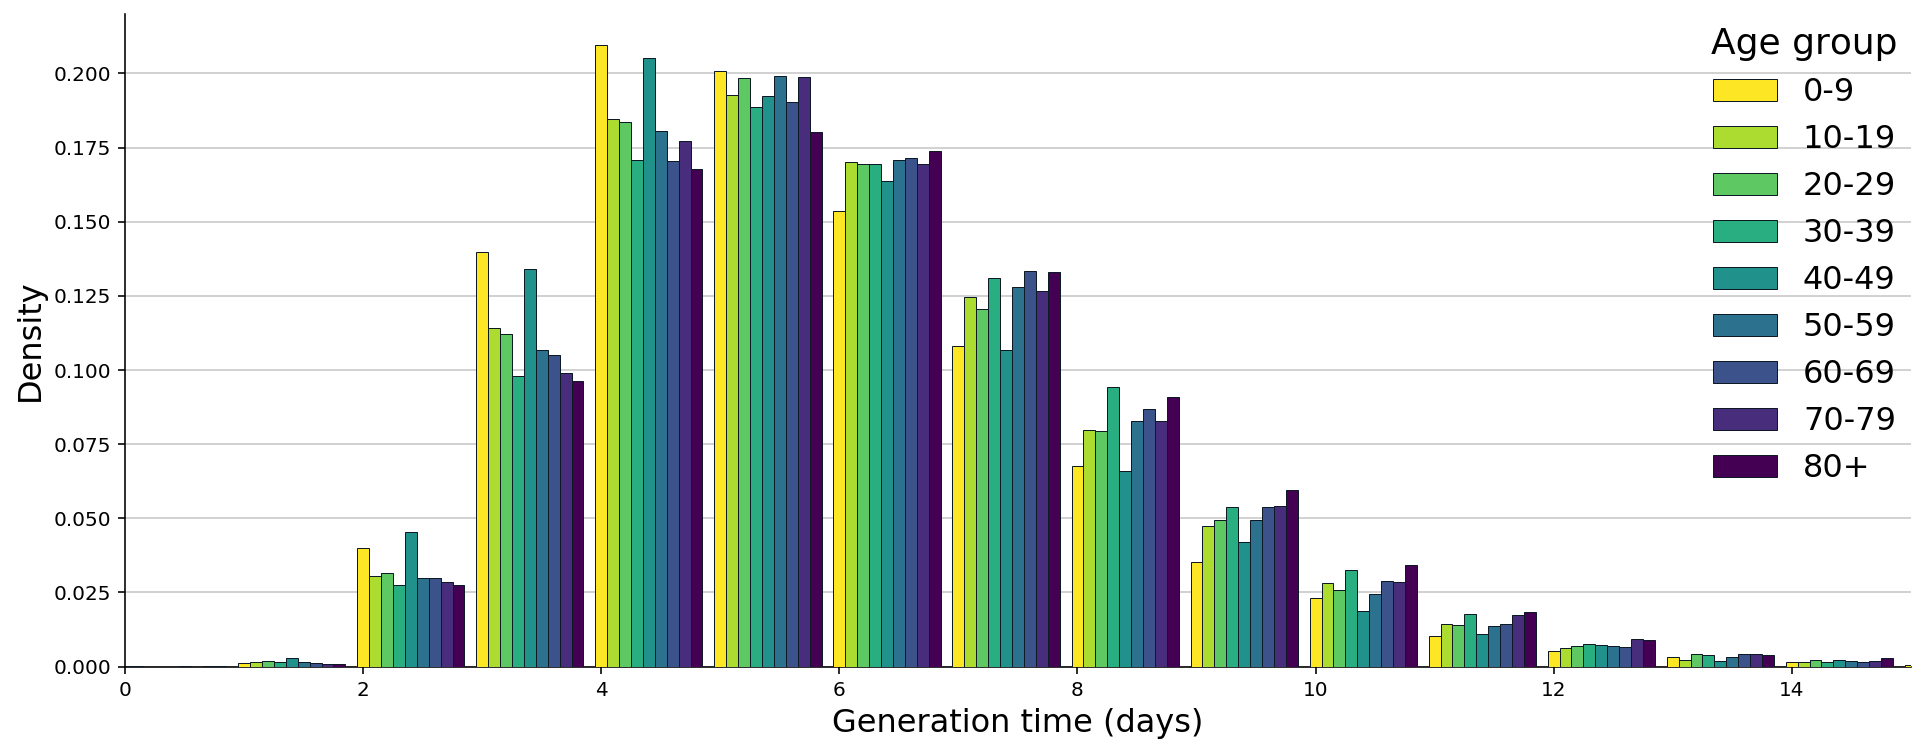

In [21]:
# Plot histogram of interaction by network type
fig, ax = plotting.BarByGroup(df_trans, groupvar = "age_group", binvar = "infector_infected_time", 
        bins = 30, group_labels = age_group_labels, 
        density = True, xlimits = [0, 15], title = "", xlabel = "Generation time (days)", ylabel = "Density", 
        legend_title = "Age group")

### Transmission events by age of infected individual and location of infection event

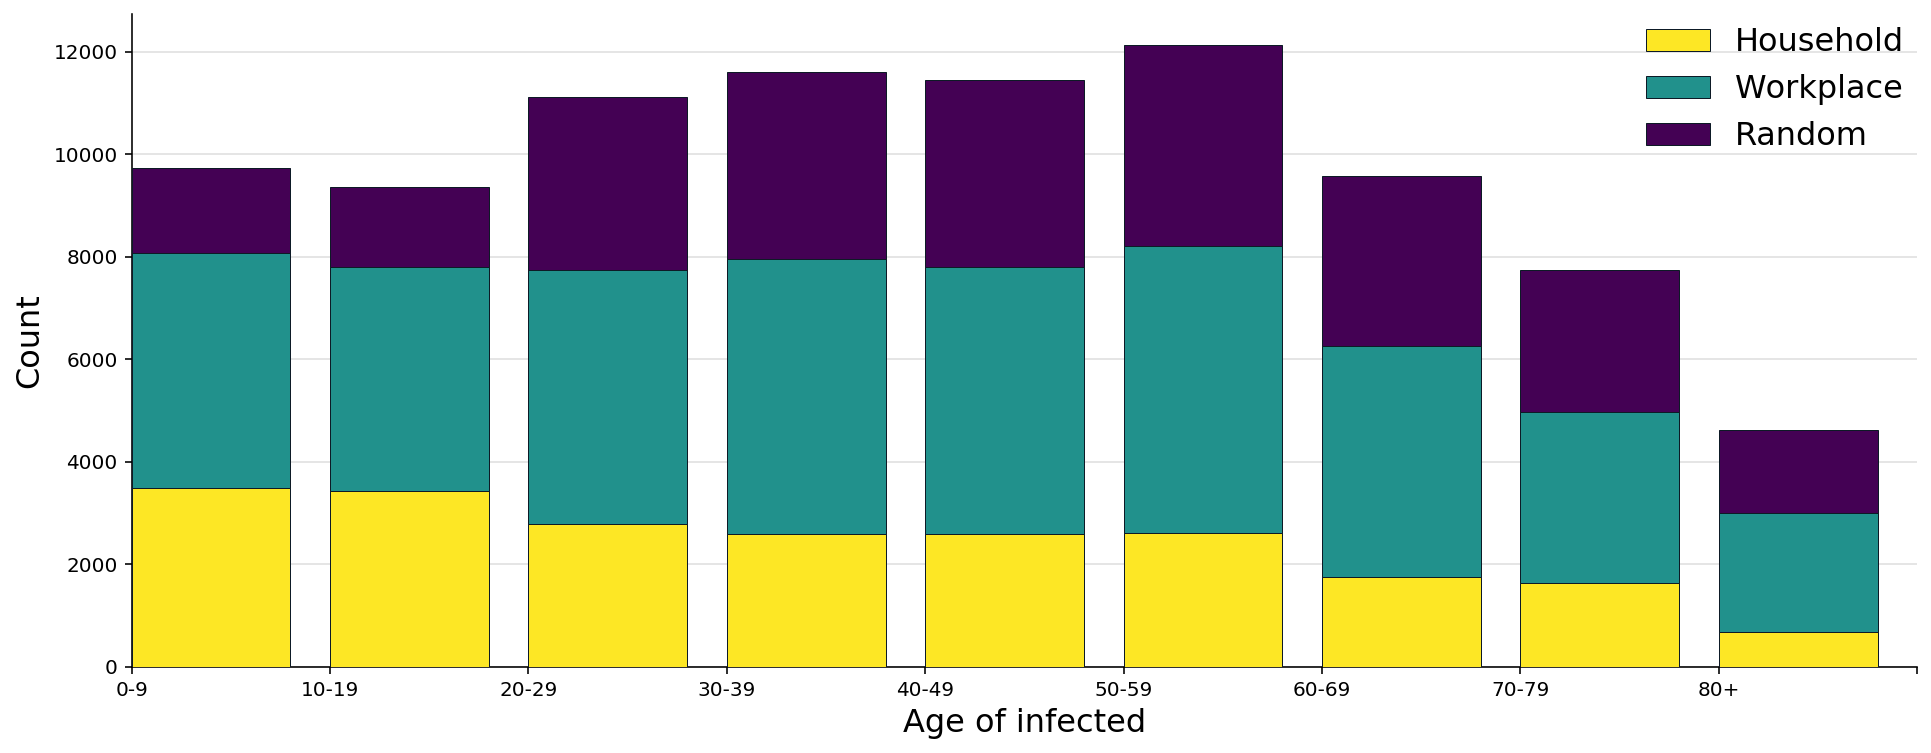

In [22]:
# fixme: adjust x tick labels

plt.rcParams['figure.figsize'] = [16, 6]
fig, ax = plotting.PlotStackedHistByGroup(df_trans[df_trans.infector_network >= 0], 
        groupvar = "infector_network", countvar = "age_group",
        NBINS = n_age, group_labels = ["Household", "Workplace", "Random"],
        xlabel = "Age of infected", ylabel = "Count",
        legend_loc = "best", xticklabels = age_group_labels)

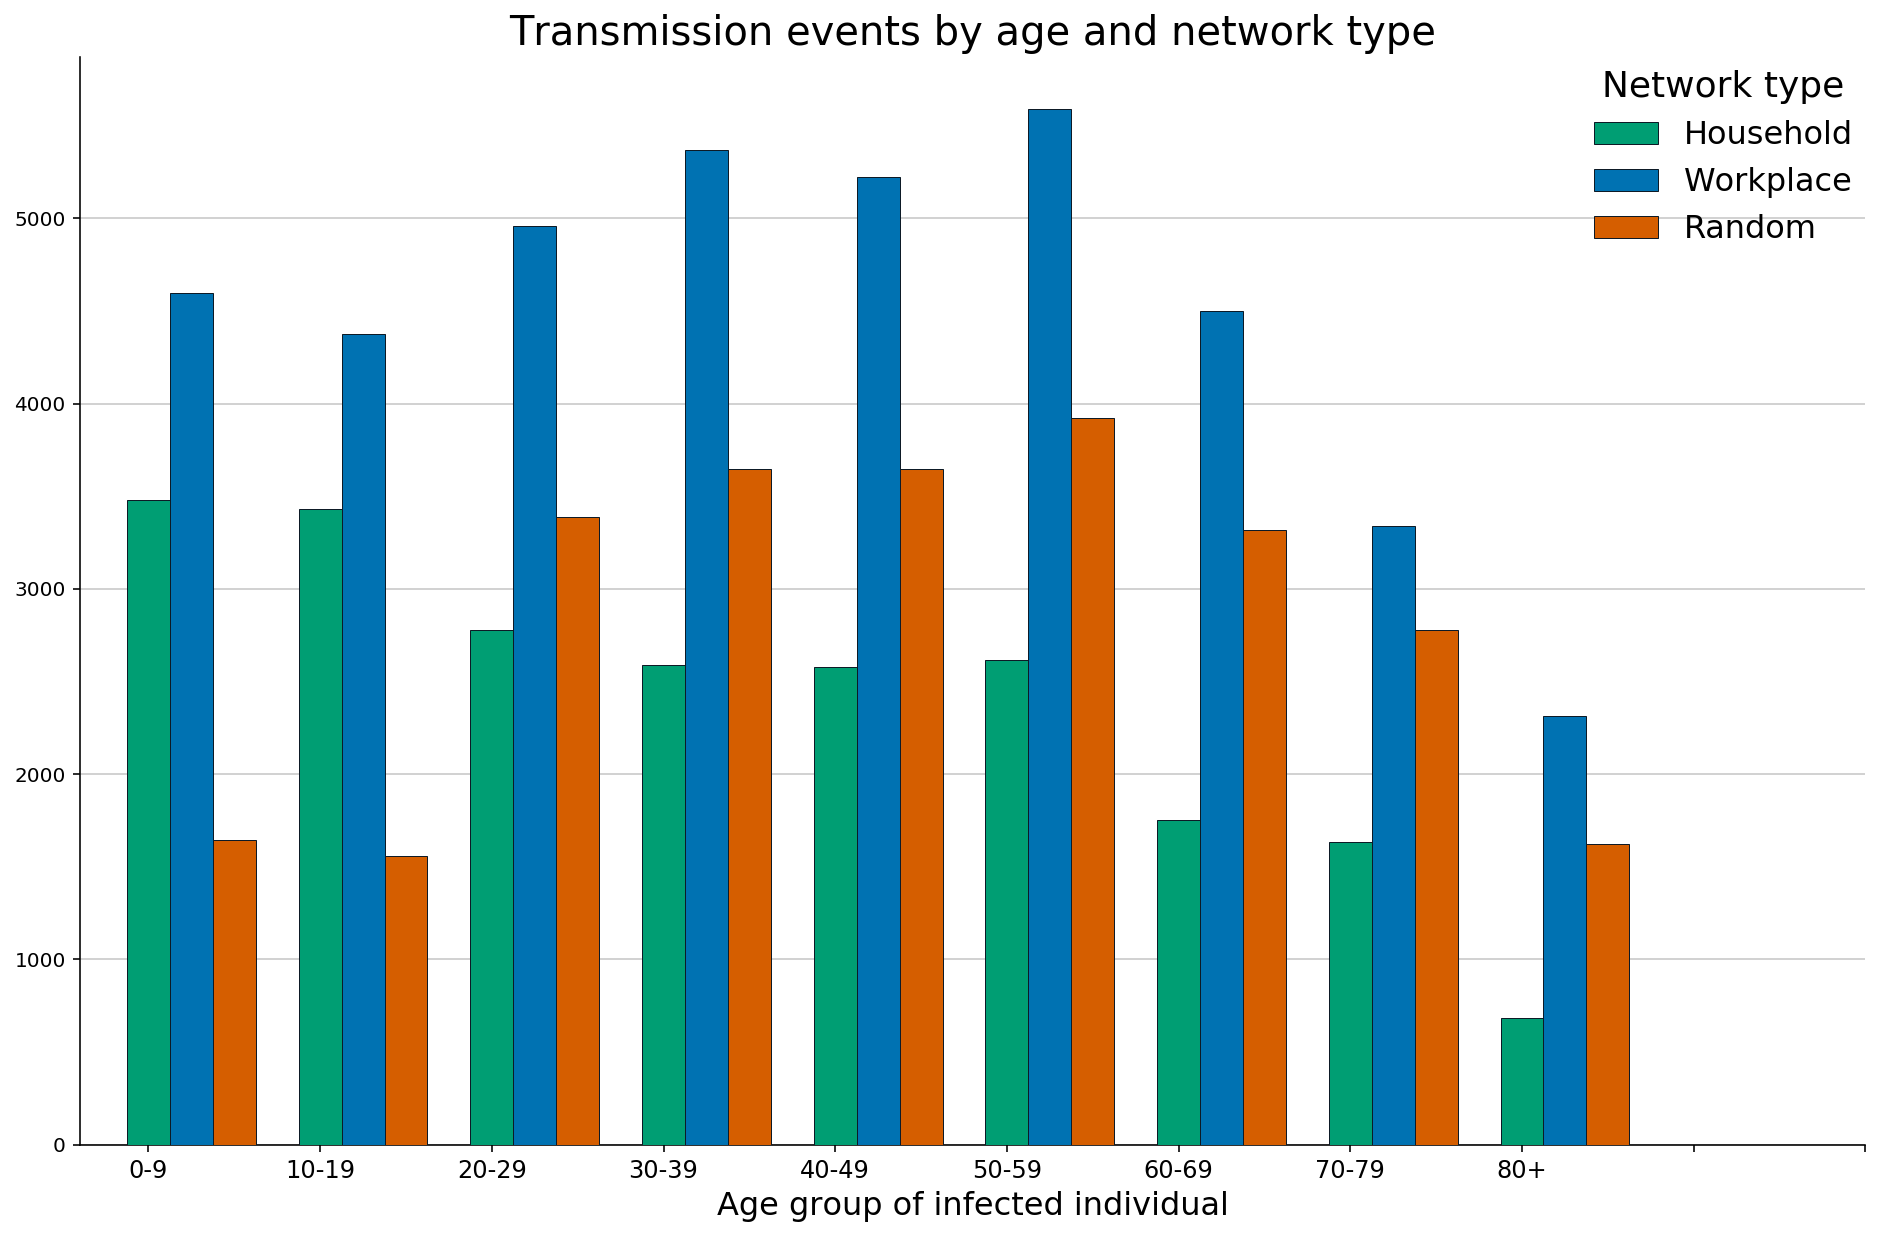

In [23]:
# fixme: adjust x tick labels
importlib.reload(plotting)
plt.rcParams['figure.figsize'] = [16, 10]

fig, ax = plotting.BarByGroup(df_trans[df_trans.infector_network >= 0], 
    groupvar = "infector_network", binvar = "age_group", 
    groups = [0, 1, 2], bins = n_age, group_colours = plotting.network_colours,
    group_labels = ["Household", "Workplace", "Random"], 
    xlabel = "Age group of infected individual", 
    title = "Transmission events by age and network type",
    legend_title = "Network type", xticklabels = age_group_labels)

### Transmission events stratified by age

Of all transmission events, the following figure shows the distribution of transmission events (2D histogram) stratified by the age of the source and recipient.  

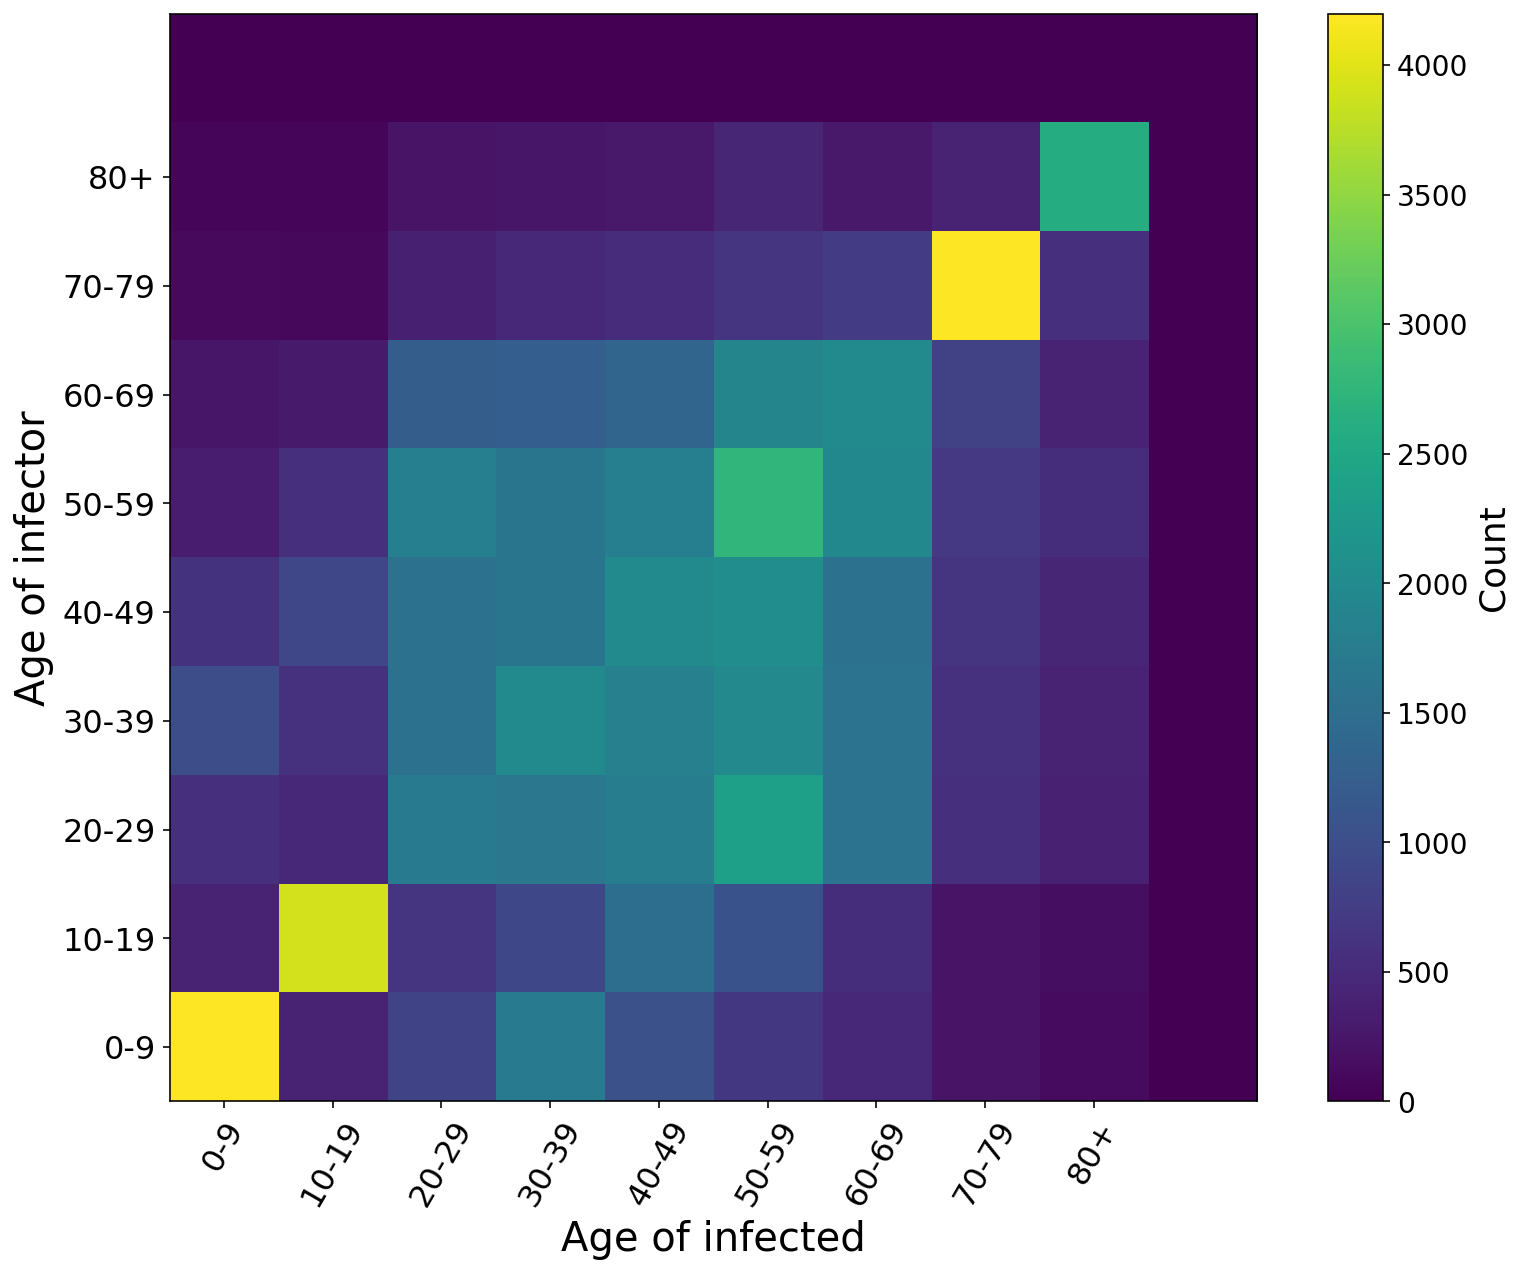

In [24]:
fig, ax = plotting.transmission_heatmap_by_age(df_trans, "age_group", "age_group_2", bins = n_age + 1,
        xlabel = "Age of infected", ylabel = "Age of infector", legend_title = "Count",
        xticklabels = age_group_labels, yticklabels = age_group_labels)

### Transmission events by age (normalised by age of recipient)

Of all transmission events to individuals of a particular age group, the following figure shows the distribution of the age of those that infect them.  

/Users/bryn/git/covid/relase-candidate/sandbox/plotting.py:766: RuntimeWarning: invalid value encountered in true_divide
  array = array/array.sum(axis = 0)


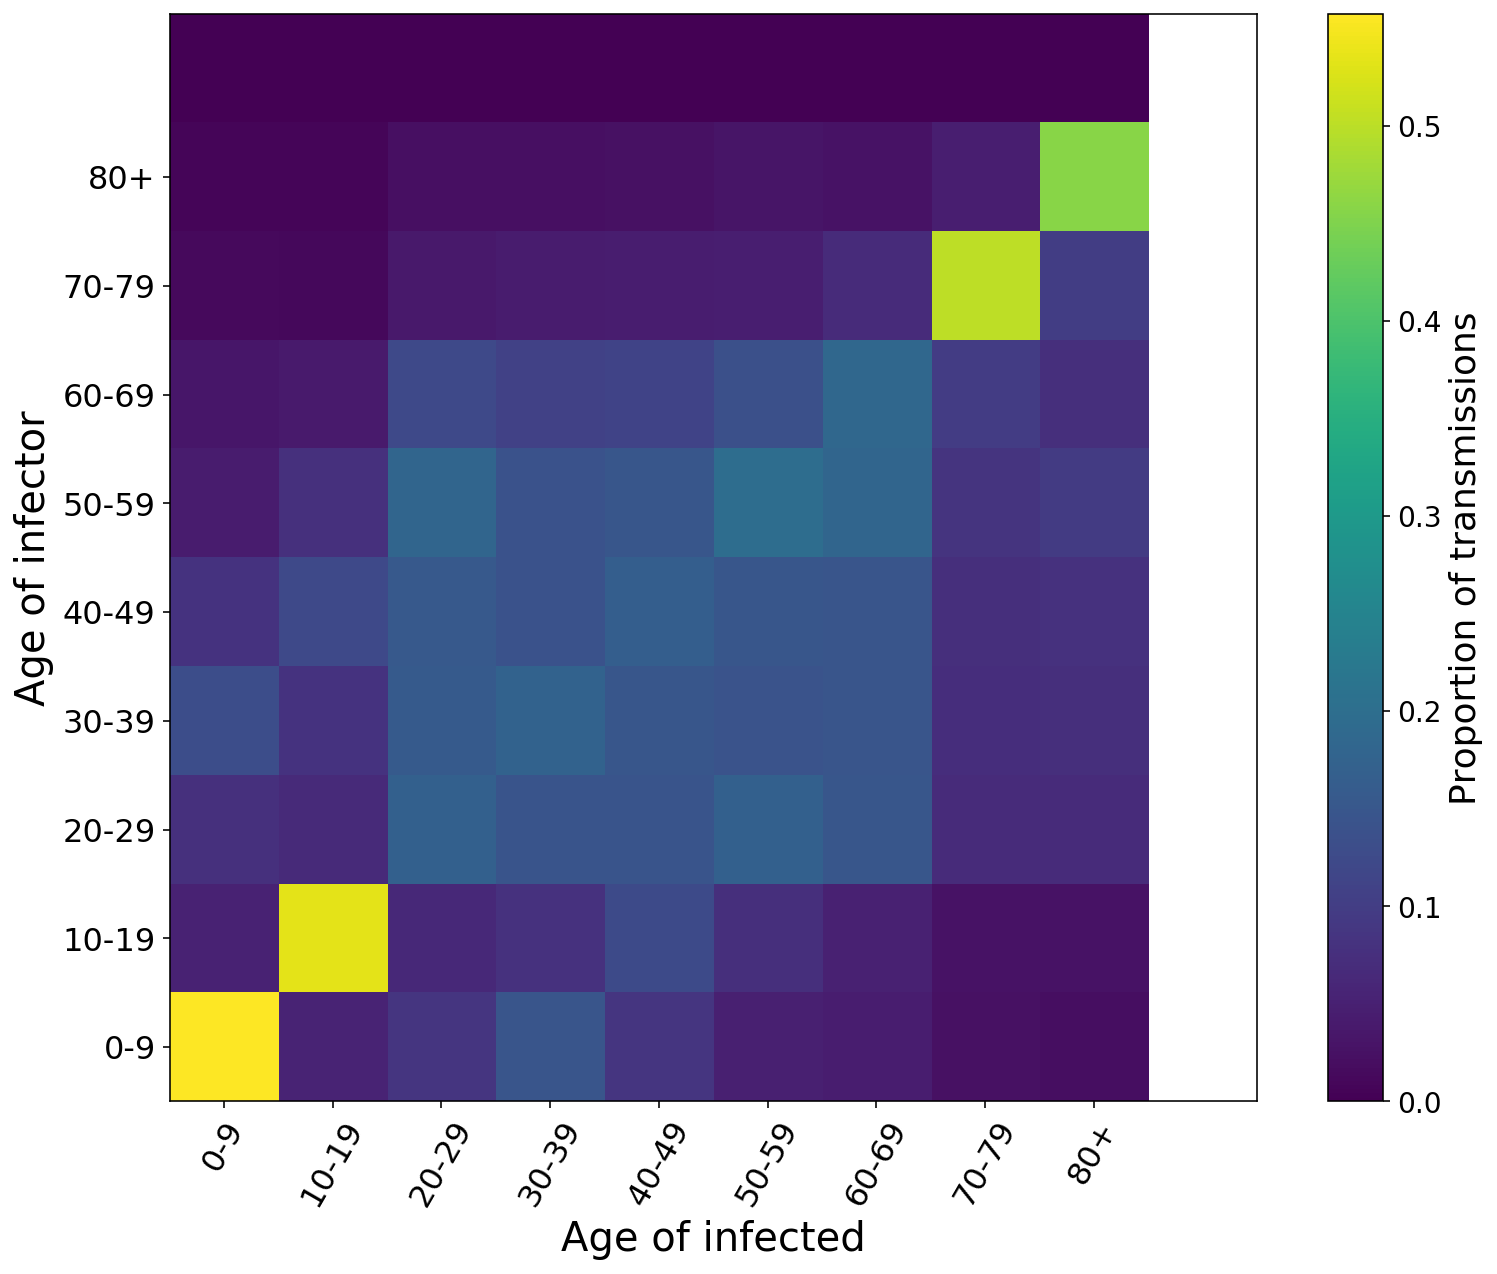

In [25]:
fig, ax = plotting.transmission_heatmap_by_age(df_trans, "age_group", "age_group_2", bins = n_age + 1,
        xlabel = "Age of infected", ylabel = "Age of infector", legend_title = "Proportion of transmissions",
        xticklabels = age_group_labels, yticklabels = age_group_labels, normalise = True)

The same data can also be visualised as a stacked bar chart.  

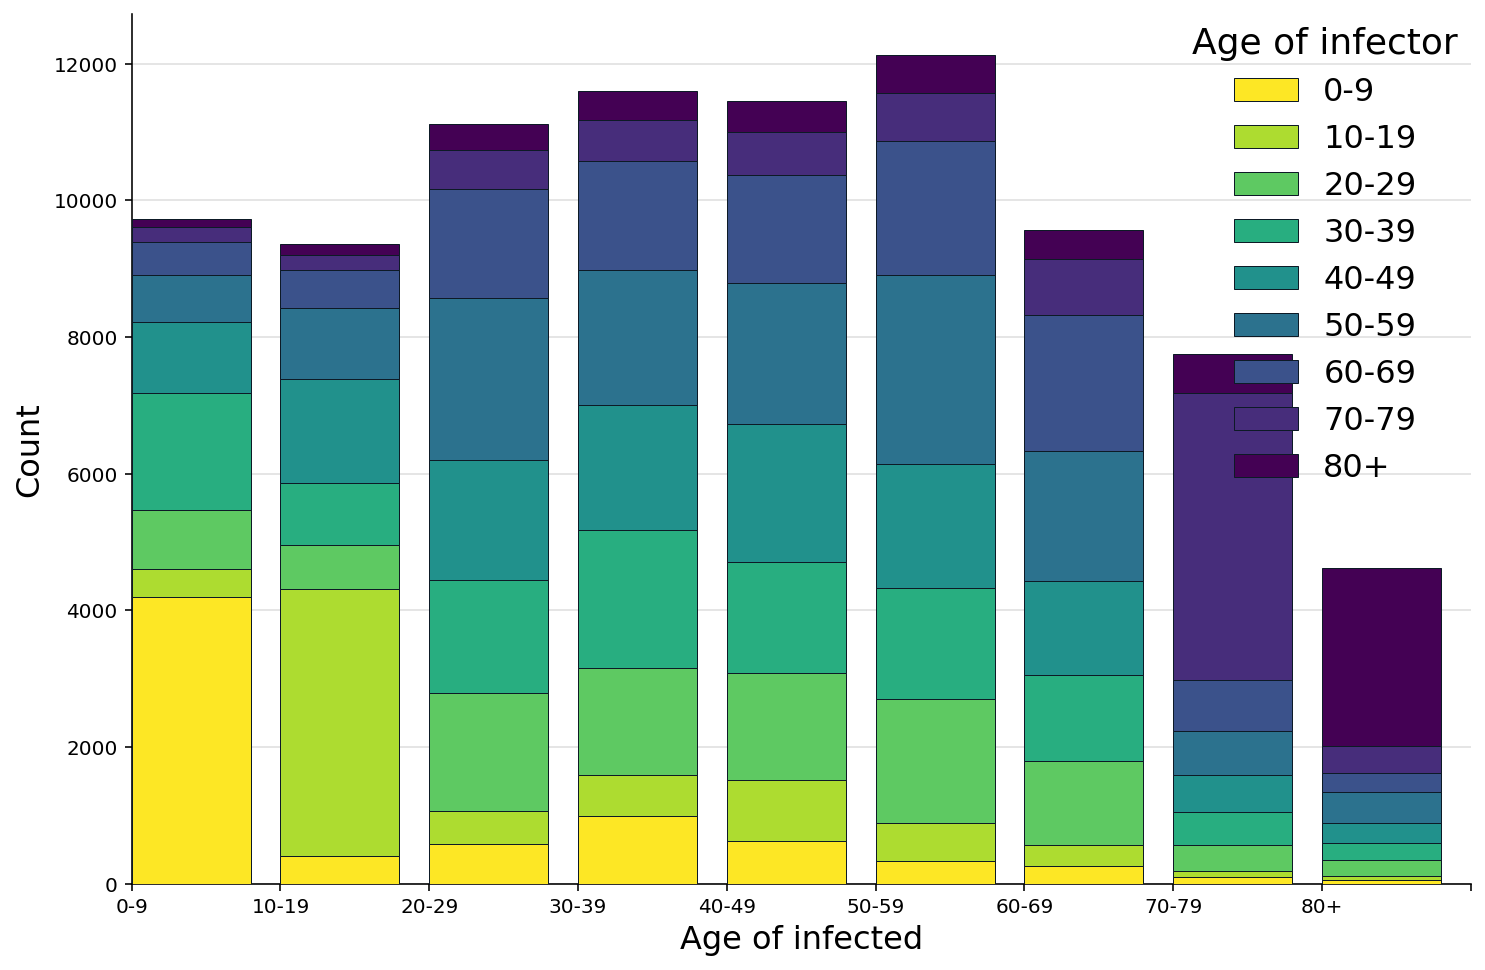

In [35]:
# fixme: tick label font sizes, alignment of tick labels
fig, ax = plotting.PlotStackedHistByGroup(df_trans[df_trans.infector_network >= 0], 
        groupvar = "age_group_2", countvar = "age_group",
        NBINS = n_age, group_labels = age_group_labels,
        xlabel = "Age of infected", ylabel = "Count",
        legend_title = "Age of infector",
        legend_loc = "best", xticklabels = age_group_labels)

### Distribution of transmission events by age and network type

In [27]:
# fixme: legend reshaping final axis object
# Distribution of trans events by age & network type
# (i.e. network within which transmission event occured)
# fig, ax = plotting.AgeHeatMapTransmissionsGroups(df_trans[df_trans.infector_network >= 0], 
#         "age_group", "age_group_2", by = "infector_network", NBINS = n_age + 1, 
#         xlabel = "Age of infected", ylabel = "Age of infector", 
#         legend_title = "Count", xticklabels = age_group_labels, 
#         yticklabels = age_group_labels)

In [28]:
# fixme: legend reshaping final axis object

# Dist. of transmission events by network type 
# normalised across age cohorts of infected individuals
# (i.e. network within which transmission event occured)
# fig, ax = plotting.transmission_heatmap_by_age_by_panels(df_trans[df_trans.infector_network >= 0], 
#         "age_group", "age_group_2", panelvar = "infector_network", NBINS = n_age + 1, 
#         xlabel = "Age of infected", ylabel = "Age of infector", 
#         panel_labels = interaction_labels, 
#         legend_title = "Proportion", xticklabels = age_group_labels, 
#         yticklabels = age_group_labels, normalise = True)

# Empirical effective reproductive number ($R_{eff}$) <a class="anchor" id="effective-reproduction-number"></a>
[[Home](#home)]

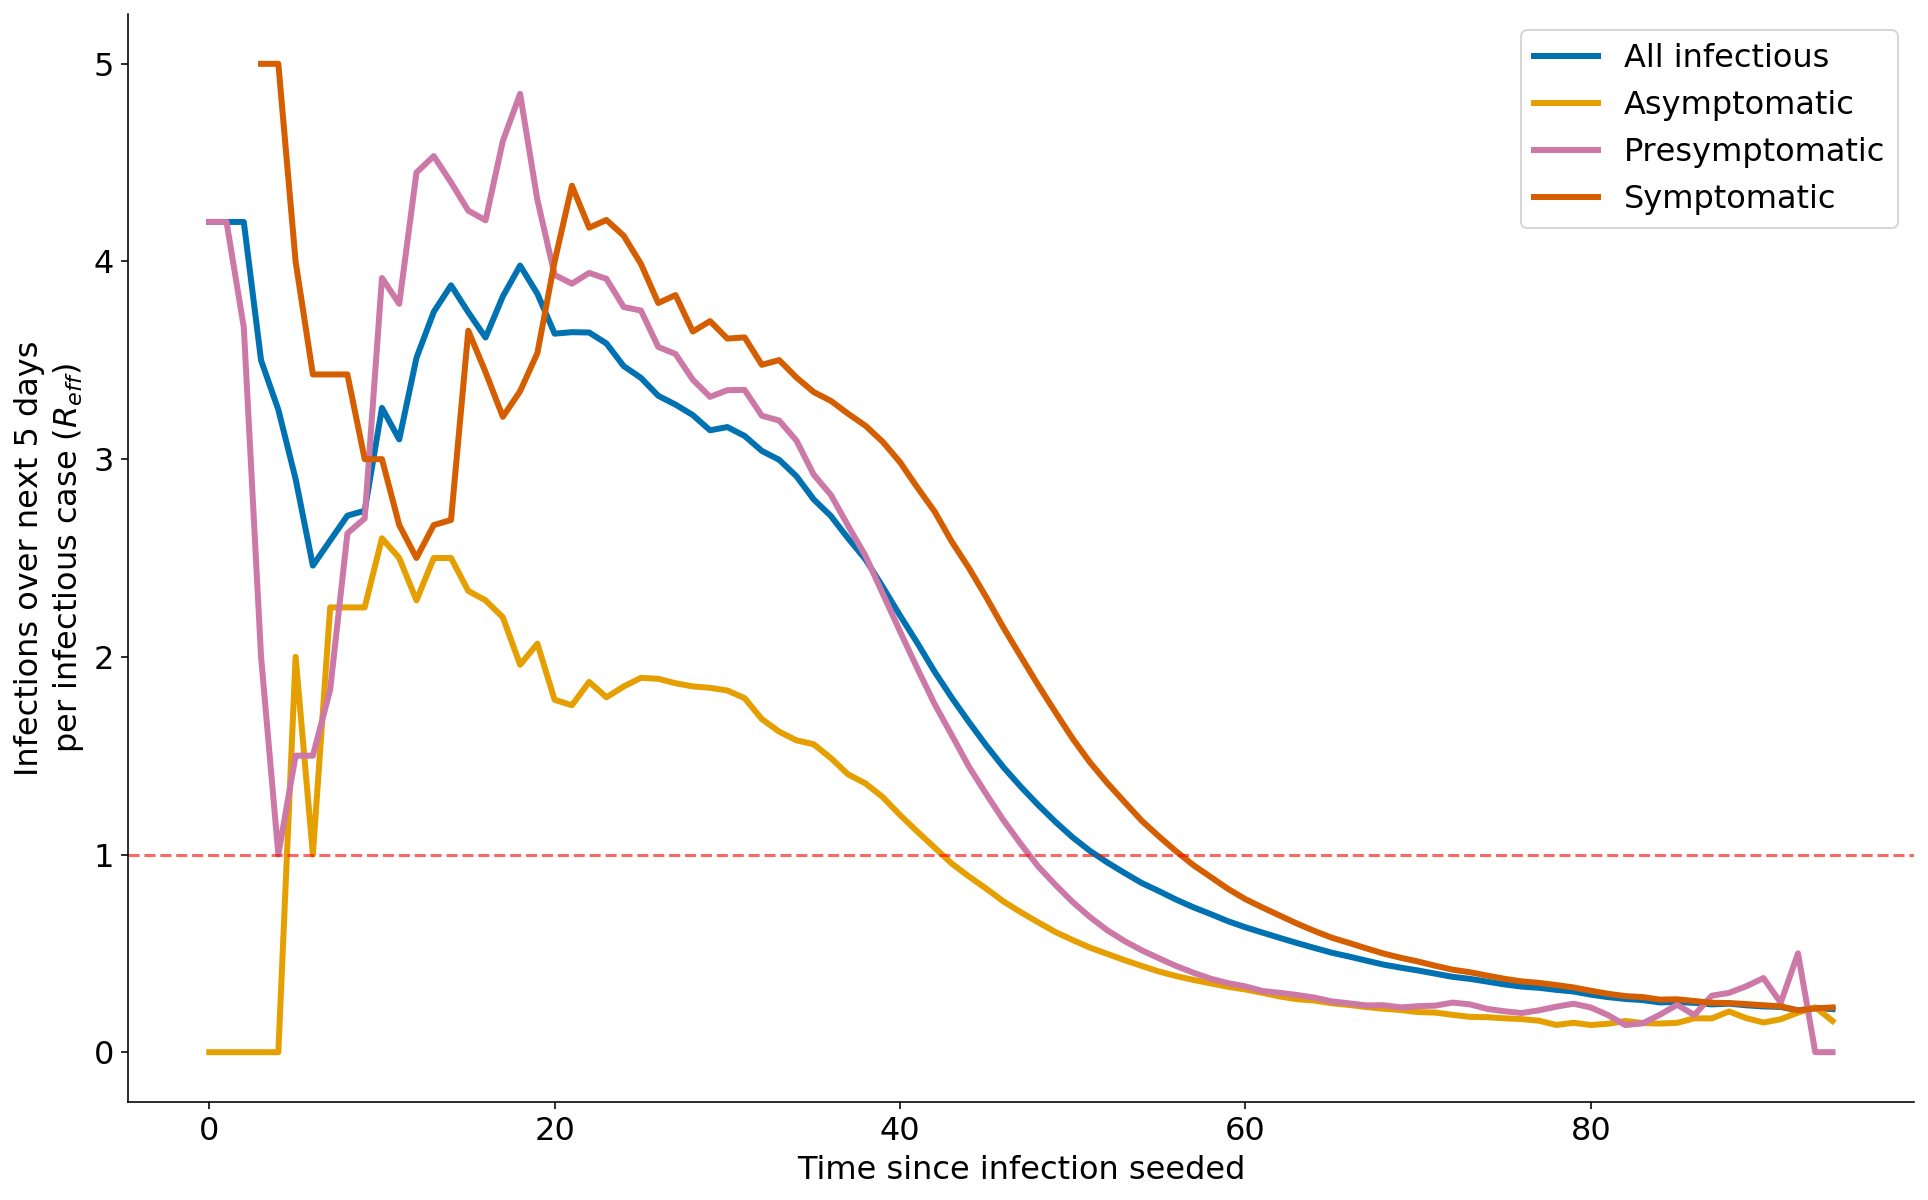

In [29]:
# fixme: redo calculations (currently under-estimates R-eff as takes individuals in a disease state at the start of the window
# and assumes they are in that state for the remainder of the window period)
fig, ax = plotting.PlotREffective(df_indiv, df_trans, start = 1, stop = 100, window = 5)

# Age-stratified outputs <a class="anchor" id="age-stratified-outputs"></a>

Age stratification across different states.  Pr(Age | State)

[[Home](#home)]

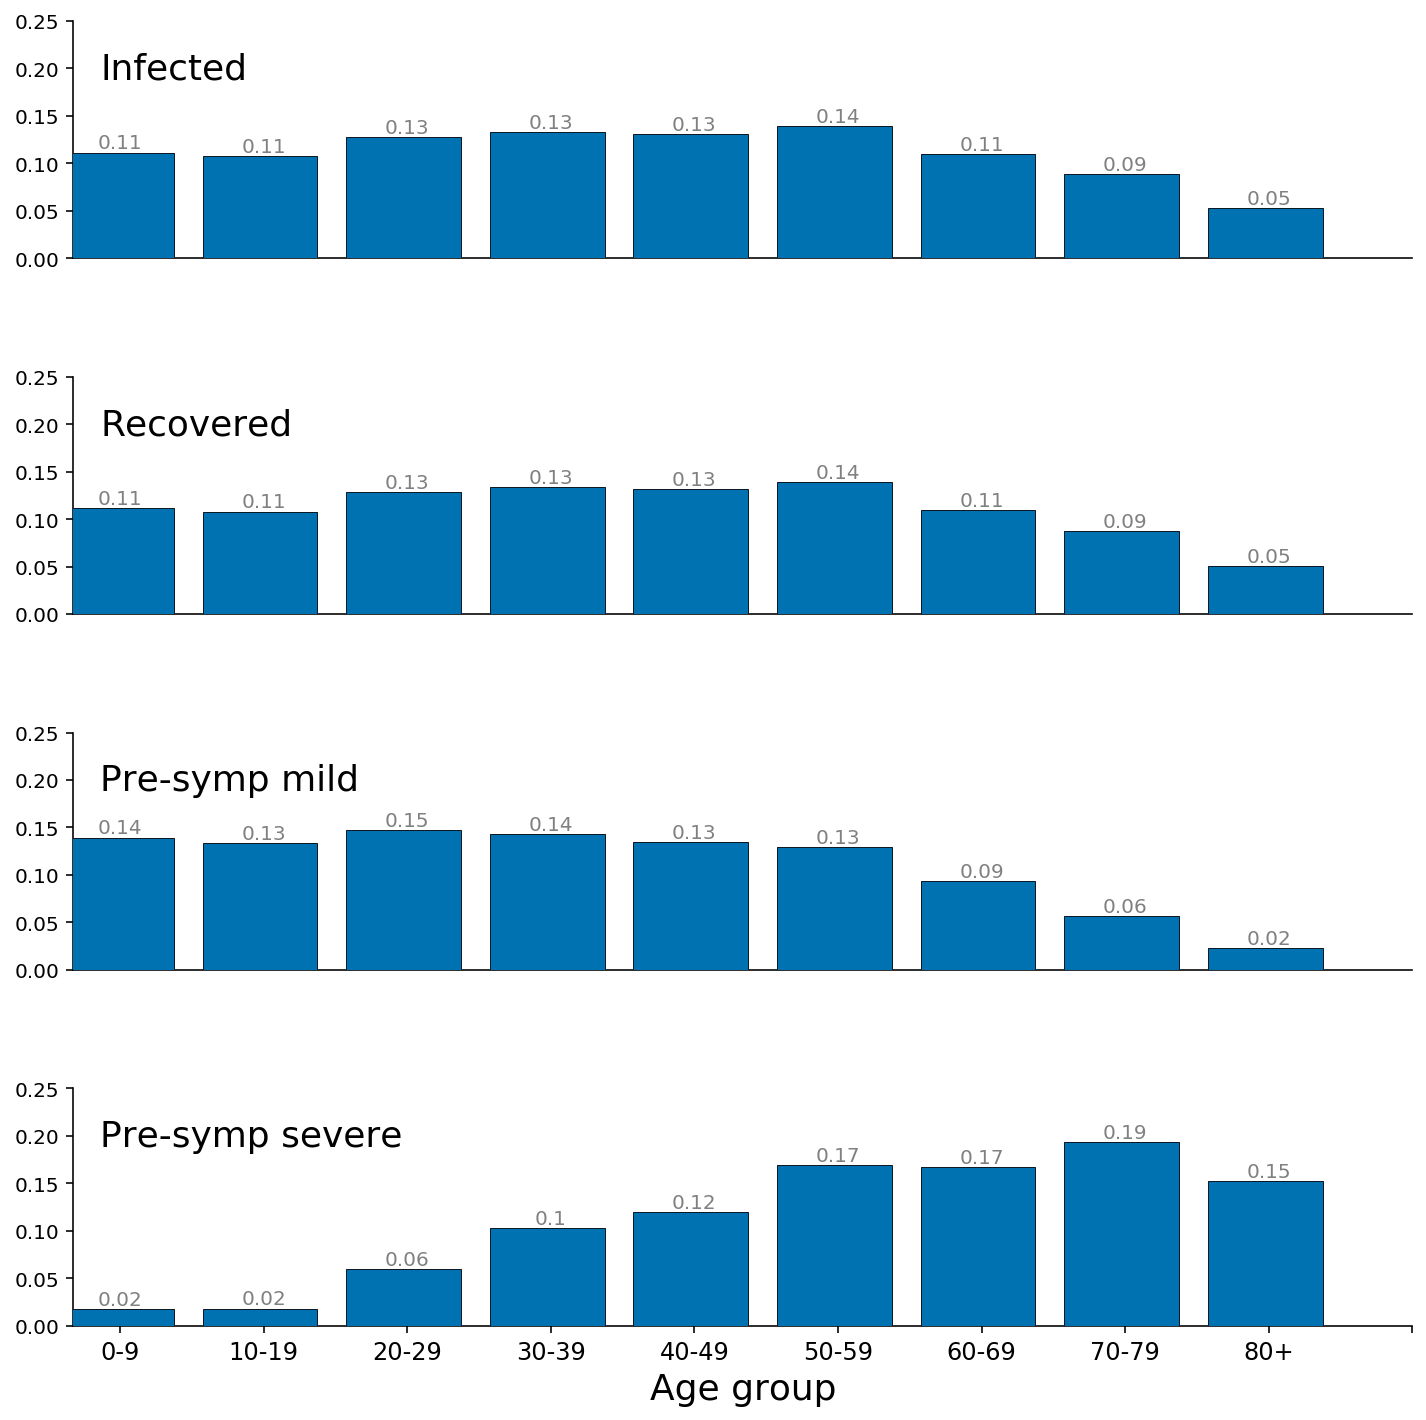

In [39]:
plt.rcParams['figure.figsize'] = [12, 12]
groupvars = ["time_infected", "time_recovered", "time_presypmtomatic_mild", "time_presypmtomatic_severe"]
labels = ["Infected", "Recovered", "Pre-symp mild", "Pre-symp severe"]

importlib.reload(plotting)
fig, ax = plotting.PlotHistByAge(df_indiv, groupvars = groupvars, group_labels = labels,
    NBINS = n_age -1 , density = True, xticklabels = age_group_labels, xlabel = "Age group",
    ylim = 0.25)

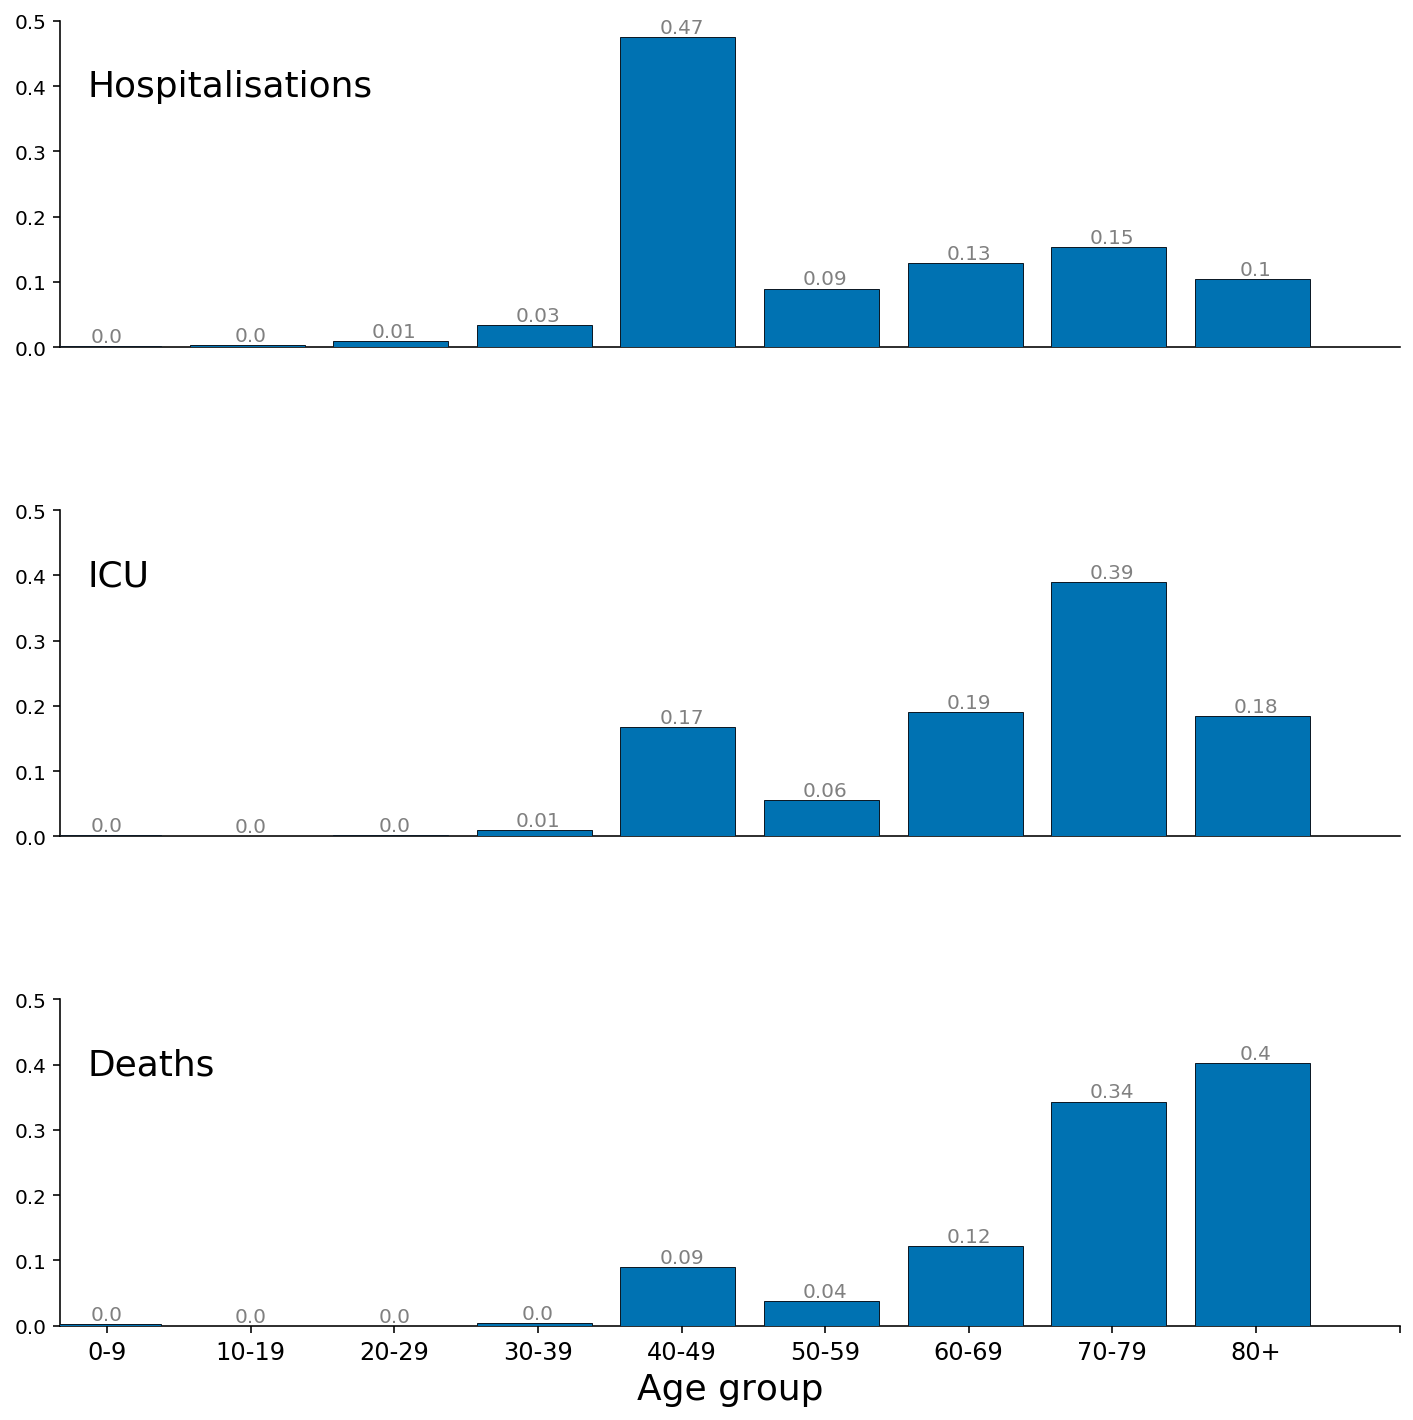

In [38]:
plt.rcParams['figure.figsize'] = [12, 12]
groupvars = ["time_hospitalised", "time_critical", "time_death"]
labels = ["Hospitalisations", "ICU", "Deaths"]

importlib.reload(plotting)
fig, ax = plotting.PlotHistByAge(df_indiv, groupvars = groupvars, group_labels = labels,
    NBINS = n_age -1 , density = True, xticklabels = age_group_labels, xlabel = "Age group",
    ylim = 0.5)

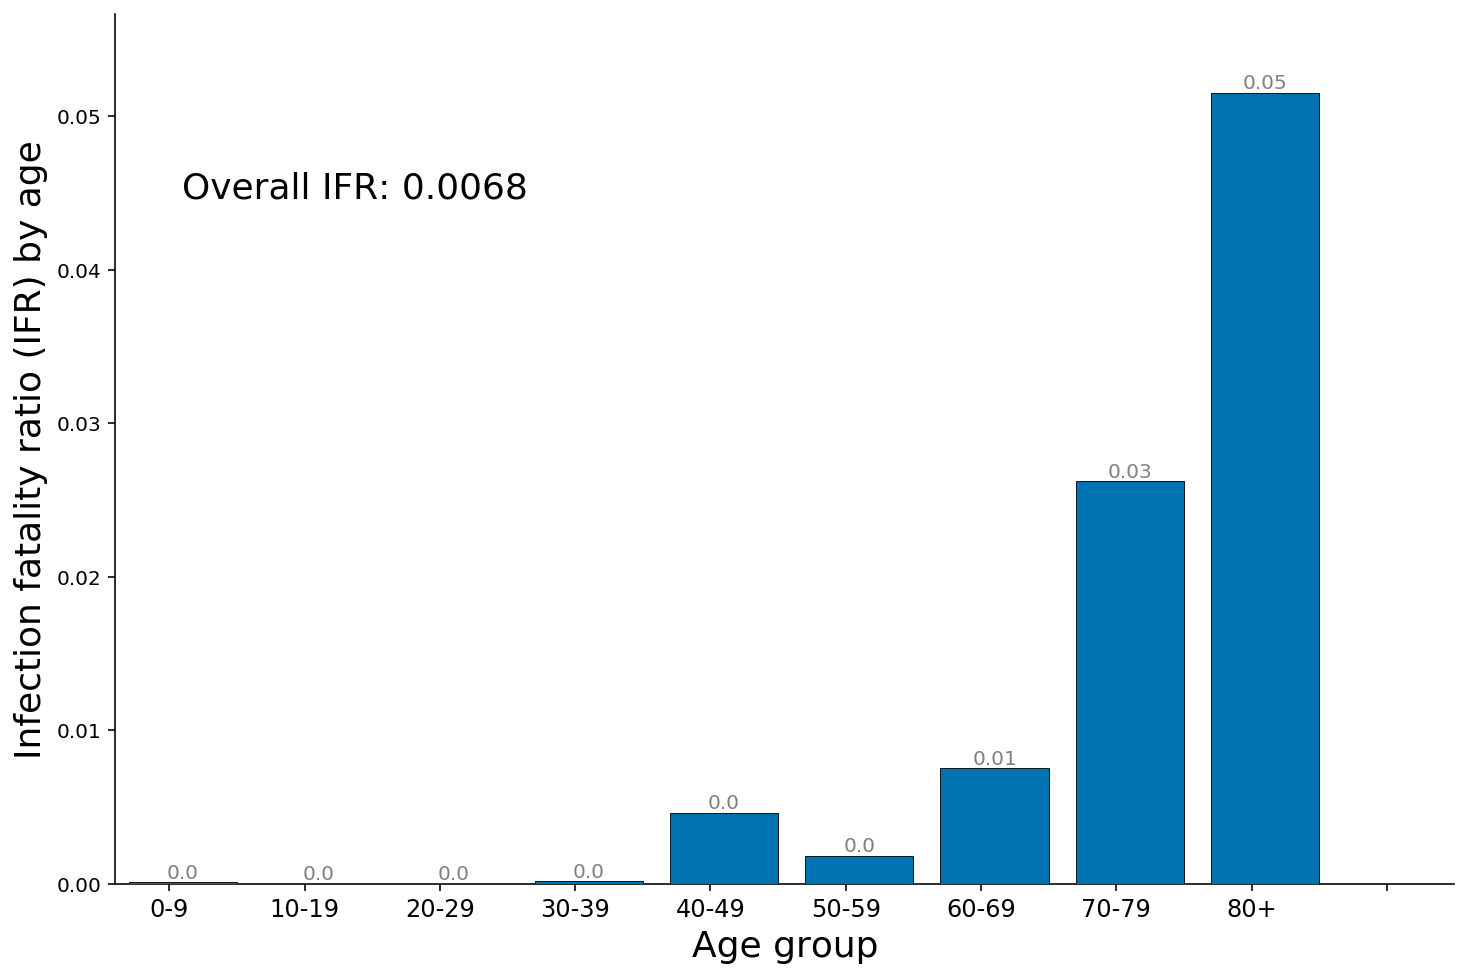

In [37]:
plt.rcParams['figure.figsize'] = [12, 8]
fig, ax = plotting.PlotHistIFRByAge(df_indiv, "time_death", "time_infected", NBINS = n_age -1, 
    xticklabels = age_group_labels, xlabel = "Age group")